# Weekly task 2 - Dicky Adi

## Import Library

In [1]:
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
import torch
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim
from torch.utils.data import DataLoader, Dataset, random_split
from torchinfo import summary
from sklearn.metrics import classification_report, confusion_matrix
from sklearn.preprocessing import MinMaxScaler
from tqdm import tqdm

## Read and basic knowledge of the dataset

In [2]:
df = pd.read_csv('diabetes.csv')

In [3]:
df

,Pregnancies,Glucose,BloodPressure,SkinThickness,Insulin,BMI,DiabetesPedigreeFunction,Age,Outcome
0,6,148,72,35,0,33.6,0.627,50,1
1,1,85,66,29,0,26.6,0.351,31,0
2,8,183,64,0,0,23.3,0.672,32,1
3,1,89,66,23,94,28.1,0.167,21,0
4,0,137,40,35,168,43.1,2.288,33,1
...,...,...,...,...,...,...,...,...,...
763,10,101,76,48,180,32.9,0.171,63,0
764,2,122,70,27,0,36.8,0.340,27,0
765,5,121,72,23,112,26.2,0.245,30,0
766,1,126,60,0,0,30.1,0.349,47,1


In [4]:
df.isnull().sum()

Pregnancies                 0
Glucose                     0
BloodPressure               0
SkinThickness               0
Insulin                     0
BMI                         0
DiabetesPedigreeFunction    0
Age                         0
Outcome                     0
dtype: int64

In [5]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 768 entries, 0 to 767
Data columns (total 9 columns):
 #   Column                    Non-Null Count  Dtype  
---  ------                    --------------  -----  
 0   Pregnancies               768 non-null    int64  
 1   Glucose                   768 non-null    int64  
 2   BloodPressure             768 non-null    int64  
 3   SkinThickness             768 non-null    int64  
 4   Insulin                   768 non-null    int64  
 5   BMI                       768 non-null    float64
 6   DiabetesPedigreeFunction  768 non-null    float64
 7   Age                       768 non-null    int64  
 8   Outcome                   768 non-null    int64  
dtypes: float64(2), int64(7)
memory usage: 54.1 KB


In [6]:
cols = df.columns.to_list()

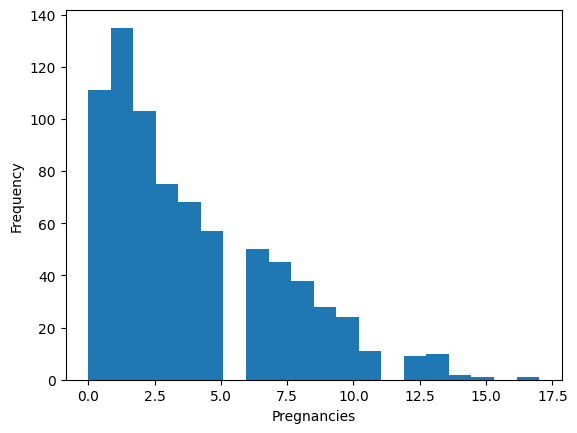

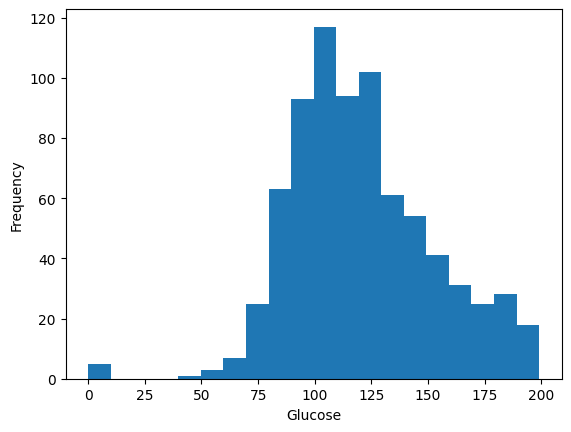

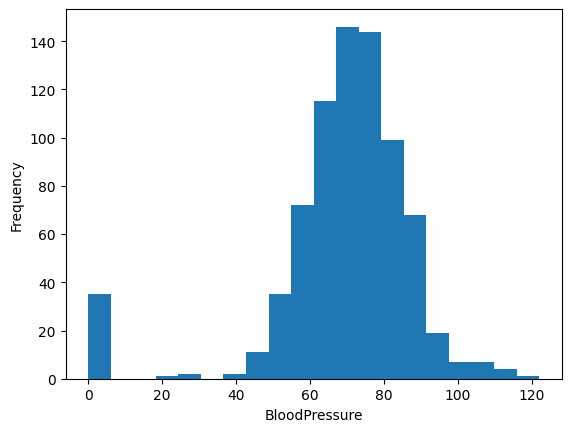

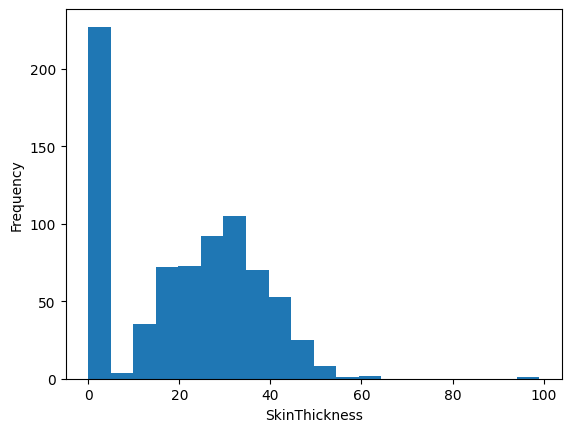

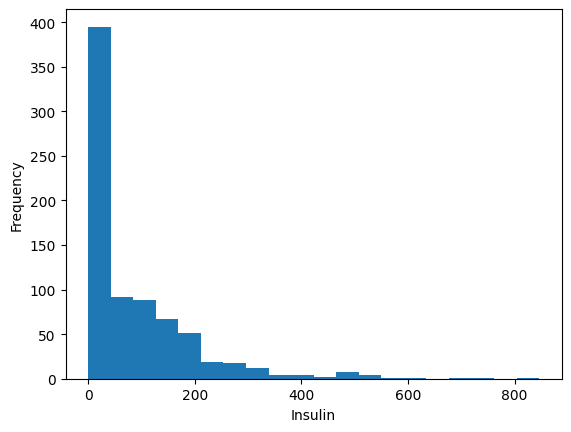

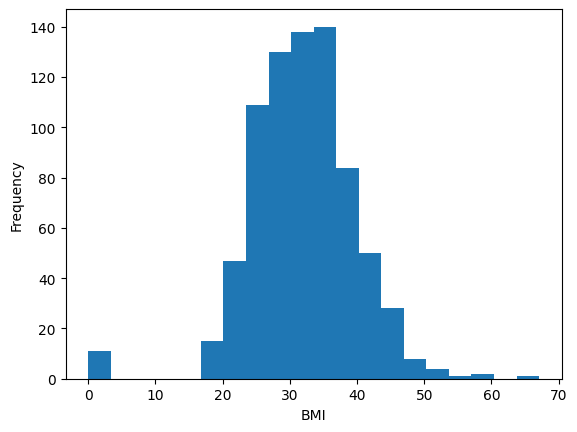

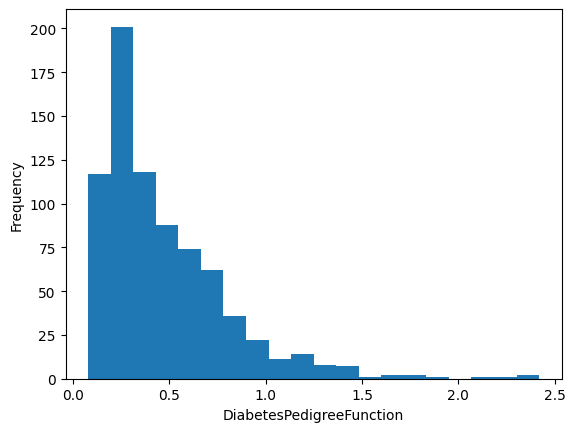

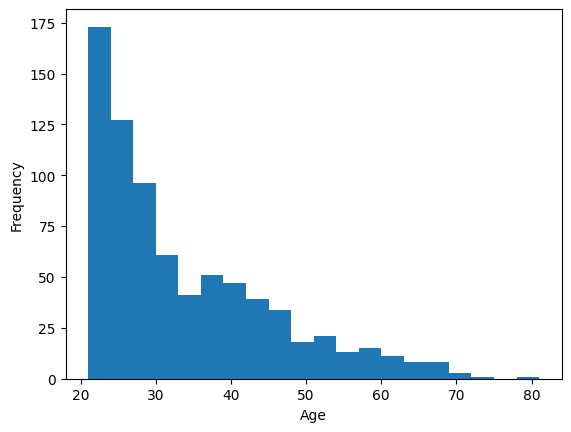

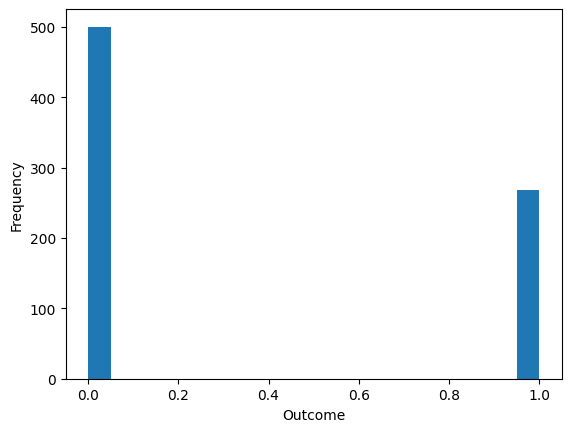

In [7]:
for col in cols:
    plt.hist(df[col], bins=20)
    plt.xlabel(col)
    plt.ylabel('Frequency')
    plt.show()

## Outliers handling

Based on above histogram visualization, seems like there're some outliers. However, to be precise lets check the boxplot visualization

<function matplotlib.pyplot.show(close=None, block=None)>

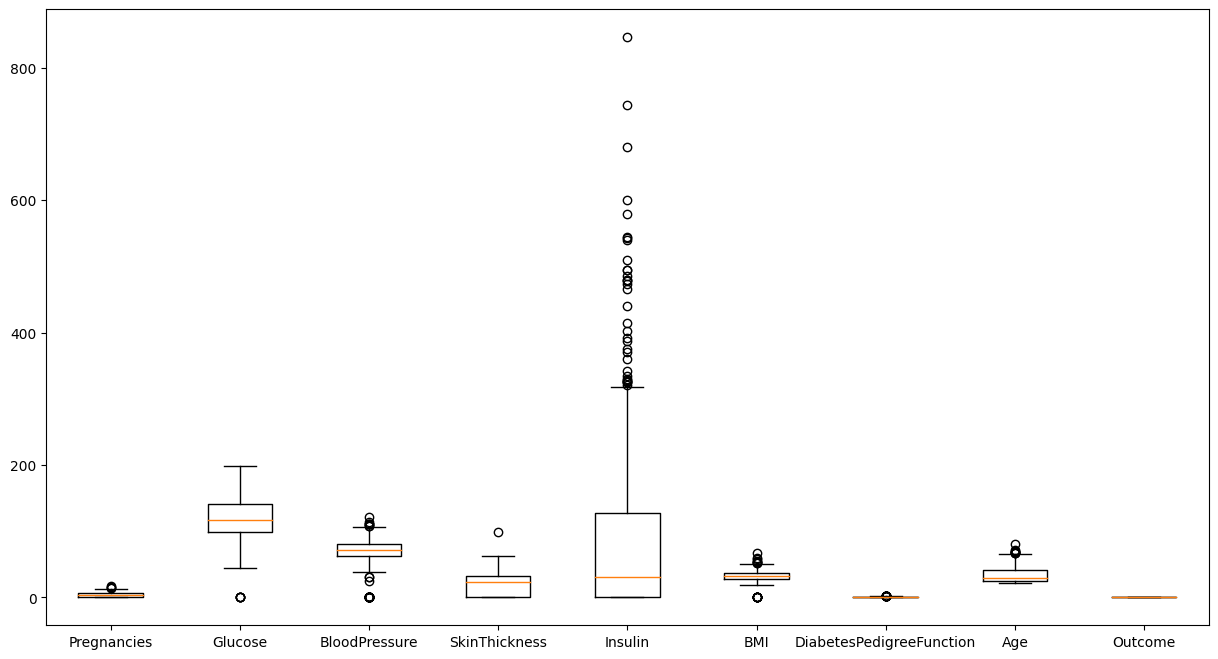

In [8]:
plt.figure(figsize=(15,8))
plt.boxplot(df.values)
plt.xticks(range(1, len(df.columns) + 1), df.columns)
plt.show

Based on boxplot visualization above, there're a lot of outliers. Therefore we need to handle these outliers carefully by logging the outliers, but before we do that let's get the outliers value

In [9]:
threshold = 2
multiplier = 1.5

dfOutliers = df.copy(deep=True)
# colsOut = df.drop(['Age', 'Outcome'], axis=1).columns.to_list()

for col in dfOutliers.drop(['Age', 'Outcome'], axis=1).columns.to_list():
    # mean = df[col].mean()
    # std = df[col].std()
    # outliers = df[col][(df[col] - mean).abs() > threshold * std]
    # dfOutliers.loc[outliers.index, col] = np.log(outliers)
    Q1 = df[col].quantile(0.25)
    Q3 = df[col].quantile(0.75)
    IQR = Q3 - Q1
    # outliers = df[col][(df[col] < Q1 - multiplier * IQR) | (df[col] > Q3 + multiplier * IQR)]
    # outliers = df[column][(df[column] < Q1 - multiplier * IQR) | (df[column] > Q3 + multiplier * IQR)]
    outliers = df[col][(df[col] < Q1 - multiplier * IQR) | (df[col] > Q3 + multiplier * IQR)]
    if outliers.dtype == 'int64':
        dfOutliers.loc[outliers.index, col] = round(np.log(outliers + 1e-10))
    else:
        dfOutliers.loc[outliers.index, col] = np.log(outliers + 1e-10)

dfOutliers

,Pregnancies,Glucose,BloodPressure,SkinThickness,Insulin,BMI,DiabetesPedigreeFunction,Age,Outcome
0,6,148,72,35,0,33.6,0.627000,50,1
1,1,85,66,29,0,26.6,0.351000,31,0
2,8,183,64,0,0,23.3,0.672000,32,1
3,1,89,66,23,94,28.1,0.167000,21,0
4,0,137,40,35,168,43.1,0.827678,33,1
...,...,...,...,...,...,...,...,...,...
763,10,101,76,48,180,32.9,0.171000,63,0
764,2,122,70,27,0,36.8,0.340000,27,0
765,5,121,72,23,112,26.2,0.245000,30,0
766,1,126,60,0,0,30.1,0.349000,47,1


## EDA

In [10]:
dfOutliers.groupby('Outcome').count()

,Pregnancies,Glucose,BloodPressure,SkinThickness,Insulin,BMI,DiabetesPedigreeFunction,Age
Outcome,,,,,,,,
0,500,500,500,500,500,500,500,500
1,268,268,268,268,268,268,268,268


Based on table above, seems like we're having an imbalance dataset

In [11]:
dfOutliers.groupby('Outcome').mean()

,Pregnancies,Glucose,BloodPressure,SkinThickness,Insulin,BMI,DiabetesPedigreeFunction,Age
Outcome,,,,,,,,
0,3.298000,109.842000,66.564000,19.664000,55.754000,29.686545,0.402329,31.190000
1,4.686567,141.085821,67.776119,21.813433,67.458955,33.792707,0.479117,37.067164


Based on the table above, seems like the the predicted diabetic has higher mean in almost all columns

<AxesSubplot: >

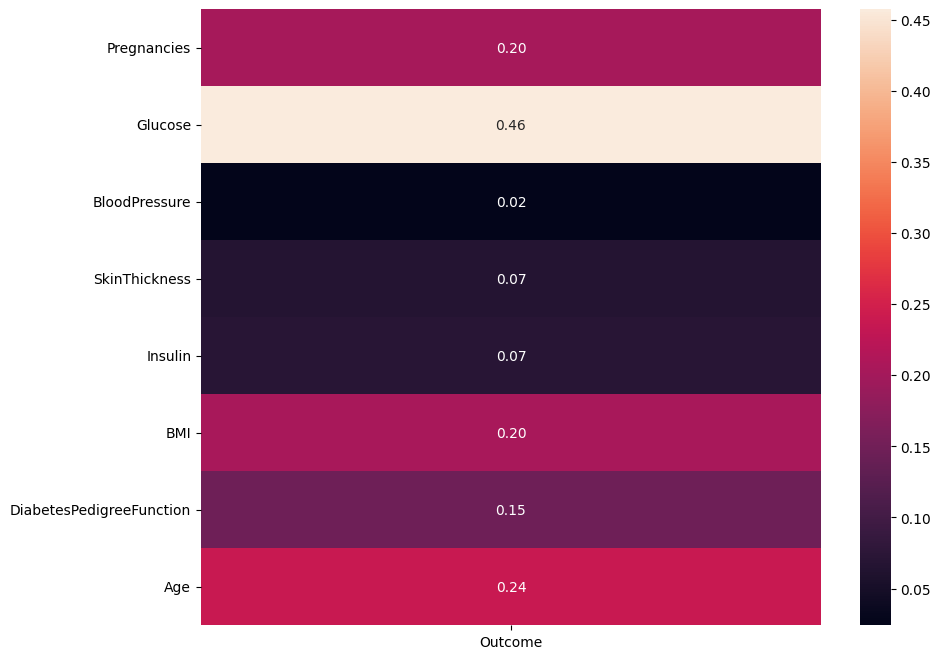

In [12]:
target = 'Outcome'
corr = dfOutliers.corr()[target]
corr = corr.drop(target)
dfCorr = pd.DataFrame(corr)
plt.figure(figsize=(10,8))
sns.heatmap(dfCorr, annot=True, fmt='.2f')

In [13]:
highCorr = dfCorr[abs(dfCorr) >= 0.2].dropna().index

In [14]:
print(highCorr)

Index(['Pregnancies', 'Glucose', 'BMI', 'Age'], dtype='object')


In [15]:
allCols = dfOutliers.copy(deep=True)
highCols = pd.concat([dfOutliers[highCorr], dfOutliers['Outcome']], axis=1)

In [16]:
scaler = MinMaxScaler()
allColsVal = scaler.fit_transform(allCols)
allColsDf = pd.DataFrame(allColsVal, columns=allCols.columns.to_list())
allColsDf

,Pregnancies,Glucose,BloodPressure,SkinThickness,Insulin,BMI,DiabetesPedigreeFunction,Age,Outcome
0,0.461538,0.770270,0.736434,0.555556,0.000000,0.775422,0.493261,0.483333,1.0
1,0.076923,0.486486,0.689922,0.460317,0.000000,0.679566,0.245283,0.166667,0.0
2,0.615385,0.927928,0.674419,0.000000,0.000000,0.634376,0.533693,0.183333,1.0
3,0.076923,0.504505,0.689922,0.365079,0.295597,0.700106,0.079964,0.000000,0.0
4,0.000000,0.720721,0.488372,0.555556,0.528302,0.905513,0.673565,0.200000,1.0
...,...,...,...,...,...,...,...,...,...
763,0.769231,0.558559,0.767442,0.761905,0.566038,0.765836,0.083558,0.700000,0.0
764,0.153846,0.653153,0.720930,0.428571,0.000000,0.819242,0.235400,0.100000,0.0
765,0.384615,0.648649,0.736434,0.365079,0.352201,0.674088,0.150045,0.150000,0.0
766,0.076923,0.671171,0.643411,0.000000,0.000000,0.727494,0.243486,0.433333,1.0


In [17]:
scaler2 = MinMaxScaler()
highColsVal = scaler2.fit_transform(highCols)
highColsDf = pd.DataFrame(highColsVal, columns=highCols.columns.to_list())
highColsDf

,Pregnancies,Glucose,BMI,Age,Outcome
0,0.461538,0.770270,0.775422,0.483333,1.0
1,0.076923,0.486486,0.679566,0.166667,0.0
2,0.615385,0.927928,0.634376,0.183333,1.0
3,0.076923,0.504505,0.700106,0.000000,0.0
4,0.000000,0.720721,0.905513,0.200000,1.0
...,...,...,...,...,...
763,0.769231,0.558559,0.765836,0.700000,0.0
764,0.153846,0.653153,0.819242,0.100000,0.0
765,0.384615,0.648649,0.674088,0.150000,0.0
766,0.076923,0.671171,0.727494,0.433333,1.0


## Modelling

Since we're using pytorch to develop the deep learning model, lets create the custom dataset first then the dataloader

In [18]:
# yHighCols = torch.tensor(highColsDf[target].values, dtype=torch.float32)
# yAllCols = torch.tensor(allColsDf[target].values, dtype=torch.float32)
# bc = np.bincount(yHighCols)
# bcAll = np.bincount(yAllCols)
# cwHigh = torch.tensor([768 / (2 * bc[0]), 768 / (2 * bc[1])])
# cwAll = torch.tensor([768 / (2 * bcAll[0]), 768 / (2 * bcAll[1])])
# print(cwHigh)
# print(cwAll)

# import pandas as pd
# import torch

# Assuming your DataFrame is named df and the column of interest is 'column_name'
# column_values = highColsDf[target].values.astype(int)
# class_counts = torch.bincount(torch.from_numpy(column_values))
# total_samples = len(column_values)
# class_weights = total_samples / (len(class_counts) * class_counts.float())

# print(class_weights)

def getClassWeight(data):
    numClasses = 2
    count0 = 0
    count1 = 0
    for _, targets in data:
        count0 += torch.sum(targets[:] == 0)
        count1 += torch.sum(targets[:] == 1)
        
    weight0 = 1 / count0
    weight1 = 1 / count1
    maxWeight = max(weight0, weight1)
    weight0Norm = weight0 / maxWeight
    weight1Norm = weight1 / maxWeight
    return torch.tensor([weight0Norm, weight1Norm])

def getPosWeight(data):
    p_neg = 0
    p_pos = 0
    for _, targets in data:
        p_neg += torch.sum(targets[:] == 0)
        p_pos += torch.sum(targets[:] == 1)
    if p_neg >= p_pos:
        posWeight = p_neg/p_pos
    else:
        posWeight = p_pos/p_neg
    return torch.tensor([posWeight])

In [19]:
if torch.cuda.is_available():
    device = torch.device('cuda')
else:
    device = torch.device('cpu')

In [20]:
classNames = ['Non-diabetic', 'Diabetic']
lr = 0.01
epochs = 250

In [21]:
class customDataset(Dataset):
    def __init__(self, dataset):
        self.data = dataset.drop(target, axis=1).values
        self.target = dataset[target].values
    def __len__(self):
        return len(self.data)
    def __getitem__(self, index):
        inputs = torch.tensor(self.data[index], dtype=torch.float32)
        targets = torch.tensor(self.target[index], dtype=torch.float32)
        return inputs, targets

dataNormal = customDataset(allColsDf)
dataHigh = customDataset(highColsDf)

In [22]:
trainRatio = .8
valRatio = .2
batchSize = 8

trainSizeNormal = int(len(dataNormal) * trainRatio)
valSizeNormal = len(dataNormal) - trainSizeNormal

trainSizeHigh = int(len(dataHigh) * trainRatio)
valSizeHigh = len(dataHigh) - trainSizeHigh

trainSetNormal, valSetNormal = random_split(dataNormal, [trainSizeNormal, valSizeNormal])
trainSetHigh, valSetHigh = random_split(dataHigh, [trainSizeHigh, valSizeHigh])

inFeatureNormal = allCols.drop(target, axis=1).shape[1]
inFeatureHigh = highCols.drop(target, axis=1).shape[1]

sizeNormal = {
    'train' : len(trainSetNormal),
    'val' : len(valSetNormal)
}

sizeHigh = {
    'train' : len(trainSetHigh),
    'val' : len(valSetHigh)
}

# BECAREFUL WHEN DEFINING THE NUM_WORKERS AND PIN_MEMORY PARAMETER IN DATALOADER, BECAUSE IT WILL RUIN THE PERFORMANCES OF YOUR GPU AND CPU IF YOU DONT HAVE HIGH SPECS
loaderNormal = {
    'train' : DataLoader(trainSetNormal, batch_size=batchSize, shuffle=True, num_workers=8, pin_memory=True),
    'val' : DataLoader(valSetNormal, batch_size=batchSize, shuffle=False, num_workers=8, pin_memory=True)
}
loaderHigh = {
    'train' : DataLoader(trainSetHigh, batch_size=batchSize, shuffle=True, num_workers=8, pin_memory=True),
    'val' : DataLoader(valSetHigh, batch_size=batchSize, shuffle=False, num_workers=8, pin_memory=True)
}

In [23]:
cwNormal = getClassWeight(loaderNormal['train'])
cwHigh = getClassWeight(loaderHigh['train'])
cwNormalDevice = cwNormal.to(device)
cwHighDevice = cwHigh.to(device)

In [24]:
# cwNormal = np.array(cwHigh)
print(cwNormal.shape)
print(cwNormal)

torch.Size([2])
tensor([0.5466, 1.0000])


In [25]:
def trainingFunction(model, epochs, loader, size, criterion, optimizer, cw, patience=5, device=device):
    trainAccLog = []
    trainLossLog = []
    validationAccLog = []
    validationLossLog = []
    epochLog = []
    model.to(device)
    # criterion.to(device)
    earlyStop = 0
    bestLoss = float('inf')

    for epoch in range(epochs):
        print(f'Epoch {epoch+1}/{epochs}')
        print('-'*10)
        epochLog.append(epoch)
        for phase in ['train', 'val']:
            if phase=='train':
                model.train()
            else:
                model.eval()
            runningLoss = .0
            runningAcc = .0
            for features, targets in tqdm(loader[phase], desc='Batch', leave=False):
                feature = features.to(device)
                target = targets.type(torch.LongTensor).to(device)
                optimizer.zero_grad()
                with torch.set_grad_enabled(phase == 'train'):
                    outputs = model(feature)
                    _, pred = torch.max(outputs, 1)
                    # print(outputs.squeeze().shape)
                    # print(target.shape)
                    # print(outputs.shape)
                    # weightedOutputs = outputs.to(device) * cw.to(device)  #### WEIGHTED LOGITS
                    # print(weightedOutputs)
                    # print(weightedOutputs.shape)
                    # print(target)
                    # print(target.shape)
                    # print(outputs.device)
                    # print(target.device)
                    loss = criterion(outputs, target)
                    if phase=='train':
                        loss.backward()
                        optimizer.step()
                runningLoss += loss.item() * features.size(0)
                runningAcc += torch.sum(pred == target).item()
                del feature, target, outputs, _, pred
                torch.cuda.empty_cache()
            epochLoss = runningLoss / size[phase]
            epochAcc = runningAcc / size[phase]
            if phase == 'train':
                trainAccLog.append(epochAcc)
                trainLossLog.append(epochLoss)
            elif phase == 'val':
                validationAccLog.append(epochAcc)
                validationLossLog.append(epochLoss)
                if patience != 0:
                    if epochLoss < bestLoss:
                        bestLoss = epochLoss
                        earlyStop = 0
                    else:
                        earlyStop += 1
            tqdm.write(f'{phase} phase Accuracy : {epochAcc:.4f} and Loss : {epochLoss:.4f}')

        if patience != 0:
            if earlyStop >= patience:
                tqdm.write(f'Early stopping, no improvement in {patience} epochs')
                break
        print()
    tqdm.write('Training Finished')
    return (model, epochLog, trainAccLog, trainLossLog, validationAccLog, validationLossLog)

In [26]:
def visLog(epochLog, trainAcc, trainLoss, validationAcc, validationLoss, supTitle):
    fig, ax = plt.subplots(nrows=2, figsize=(10,8))
    # trainAcc = [x.cpu() for x in trainAcc]
    # validationAcc = [x.cpu() for x in validationAcc]
    
    ax[0].plot(epochLog, trainLoss, label='Training Loss')
    ax[0].plot(epochLog, validationLoss, label='Validation Loss')
    ax[0].set(xlabel="Epoch", ylabel="Loss", title="Train & Validation Loss")
    
    ax[1].plot(epochLog, trainAcc, label='Training Accuracy')
    ax[1].plot(epochLog, validationAcc, label='Validation Accuracy')
    ax[1].set(xlabel="Epoch", ylabel="Accuracy", title="Train & Validation Accuracy")

    ax[0].legend()
    ax[1].legend()
    plt.suptitle(supTitle)
    fig.tight_layout(pad=2.0)
    plt.show()

In [27]:
def evalFunction(model, loader, epochLog, trainAcc, trainLoss, validationAcc, validationLoss, supTitle, device=device):
    plt.figure(figsize=(10,8))
    total = 0
    correct = 0
    pred = []
    truth = []

    with torch.no_grad():
        model.eval()
        for i, (features, targets) in enumerate(loader['val']):
            feature = features.to(device)
            target = targets.to(device)

            outputs = model(feature)
            _, preds = torch.max(outputs, 1)

            pred.extend(preds.data.cpu().numpy())
            truth.extend(target.data.cpu().numpy())

            total+=target.size(0)
            correct+=(preds==target).sum().item()
        
        visLog(epochLog, trainAcc, trainLoss, validationAcc, validationLoss, supTitle)

        print(classification_report(truth, pred, target_names=classNames))
        print(f'accuracy on the model was {100 * correct / total}%')
        cfMatrix = confusion_matrix(truth, pred)
        df = pd.DataFrame(cfMatrix, index=[i for i in classNames], columns=[i for i in classNames])
        sns.heatmap(df, annot=True, fmt='.0f')


### Model for all columns

List of model:
- model1 : deep and wide
- model2 : deep and shallow
- model3 : narrow and wide
- model4 : narrow and shallow

In [28]:
class model1(nn.Module):
    def __init__(self):
        super(model1, self).__init__()
        self.inputLayer = nn.Linear(in_features=inFeatureNormal, out_features=512)
        self.relu1 = nn.ReLU()
        self.hidden1 = nn.Linear(in_features=512, out_features=256)
        self.relu2 = nn.ReLU()
        self.hidden2 = nn.Linear(in_features=256, out_features=128)
        self.relu3 = nn.ReLU()
        self.hidden3 = nn.Linear(in_features=128, out_features=64)
        self.relu4 = nn.ReLU()
        self.hidden4 = nn.Linear(in_features=64, out_features=32)
        self.relu5 = nn.ReLU()
        self.outputLayer = nn.Linear(in_features=32, out_features=2)
    def forward(self,x):
        x = self.relu1(self.inputLayer(x))
        x = self.relu2(self.hidden1(x))
        x = self.relu3(self.hidden2(x))
        x = self.relu4(self.hidden3(x))
        x = self.relu5(self.hidden4(x))
        x = self.outputLayer(x)
        return F.softmax(x, dim=1)
model1 = model1()
summary(model1, input_size=(1,1, inFeatureNormal))

Layer (type:depth-idx)                   Output Shape              Param #
model1                                   [1, 1, 2]                 --
├─Linear: 1-1                            [1, 1, 512]               4,608
├─ReLU: 1-2                              [1, 1, 512]               --
├─Linear: 1-3                            [1, 1, 256]               131,328
├─ReLU: 1-4                              [1, 1, 256]               --
├─Linear: 1-5                            [1, 1, 128]               32,896
├─ReLU: 1-6                              [1, 1, 128]               --
├─Linear: 1-7                            [1, 1, 64]                8,256
├─ReLU: 1-8                              [1, 1, 64]                --
├─Linear: 1-9                            [1, 1, 32]                2,080
├─ReLU: 1-10                             [1, 1, 32]                --
├─Linear: 1-11                           [1, 1, 2]                 66
Total params: 179,234
Trainable params: 179,234
Non-trainable param

In [29]:
class model2(nn.Module):
    def __init__(self):
        super(model2, self).__init__()
        self.inputLayer = nn.Linear(in_features=inFeatureNormal, out_features=128)
        self.relu1 = nn.ReLU()
        self.hidden1 = nn.Linear(in_features=128, out_features=64)
        self.relu2 = nn.ReLU()
        self.hidden2 = nn.Linear(in_features=64, out_features=32)
        self.relu3 = nn.ReLU()
        self.hidden3 = nn.Linear(in_features=32, out_features=16)
        self.relu4 = nn.ReLU()
        self.hidden4 = nn.Linear(in_features=16, out_features=8)
        self.relu5 = nn.ReLU()
        self.outputLayer = nn.Linear(in_features=8, out_features=2)
    def forward(self, x):
        x = self.relu1(self.inputLayer(x))
        x = self.relu2(self.hidden1(x))
        x = self.relu3(self.hidden2(x))
        x = self.relu4(self.hidden3(x))
        x = self.relu5(self.hidden4(x))
        x = self.outputLayer(x)
        return F.softmax(x, dim=1)
model2 = model2()
summary(model2, input_size=(1,1, inFeatureNormal))

Layer (type:depth-idx)                   Output Shape              Param #
model2                                   [1, 1, 2]                 --
├─Linear: 1-1                            [1, 1, 128]               1,152
├─ReLU: 1-2                              [1, 1, 128]               --
├─Linear: 1-3                            [1, 1, 64]                8,256
├─ReLU: 1-4                              [1, 1, 64]                --
├─Linear: 1-5                            [1, 1, 32]                2,080
├─ReLU: 1-6                              [1, 1, 32]                --
├─Linear: 1-7                            [1, 1, 16]                528
├─ReLU: 1-8                              [1, 1, 16]                --
├─Linear: 1-9                            [1, 1, 8]                 136
├─ReLU: 1-10                             [1, 1, 8]                 --
├─Linear: 1-11                           [1, 1, 2]                 18
Total params: 12,170
Trainable params: 12,170
Non-trainable params: 0
Tota

In [30]:
class model3(nn.Module):
    def __init__(self):
        super(model3, self).__init__()
        self.inputLayer = nn.Linear(in_features=inFeatureNormal, out_features=512)
        self.relu1 = nn.ReLU()
        self.hidden1 = nn.Linear(in_features=512, out_features=256)
        self.relu2 = nn.ReLU()
        self.outputLayer = nn.Linear(in_features=256, out_features=2)
    def forward(self, x):
        x = self.relu1(self.inputLayer(x))
        x = self.relu2(self.hidden1(x))
        x = self.outputLayer(x)
        return F.softmax(x, dim=1)
model3 = model3()
summary(model3, input_size=(1,1, inFeatureNormal))

Layer (type:depth-idx)                   Output Shape              Param #
model3                                   [1, 1, 2]                 --
├─Linear: 1-1                            [1, 1, 512]               4,608
├─ReLU: 1-2                              [1, 1, 512]               --
├─Linear: 1-3                            [1, 1, 256]               131,328
├─ReLU: 1-4                              [1, 1, 256]               --
├─Linear: 1-5                            [1, 1, 2]                 514
Total params: 136,450
Trainable params: 136,450
Non-trainable params: 0
Total mult-adds (M): 0.14
Input size (MB): 0.00
Forward/backward pass size (MB): 0.01
Params size (MB): 0.55
Estimated Total Size (MB): 0.55

In [31]:
class model4(nn.Module):
    def __init__(self):
        super(model4, self).__init__()
        self.inputLayer = nn.Linear(in_features=inFeatureNormal, out_features=16)
        self.relu1 = nn.ReLU()
        self.hidden1 = nn.Linear(in_features=16, out_features=8)
        self.relu2 = nn.ReLU()
        self.outputLayer = nn.Linear(in_features=8, out_features=2)
    def forward(self, x):
        x = self.relu1(self.inputLayer(x))
        x = self.relu2(self.hidden1(x))
        x = self.outputLayer(x)
        return F.softmax(x, dim=1)
model4 = model4()
summary(model4, input_size=(1,1, inFeatureNormal))

Layer (type:depth-idx)                   Output Shape              Param #
model4                                   [1, 1, 2]                 --
├─Linear: 1-1                            [1, 1, 16]                144
├─ReLU: 1-2                              [1, 1, 16]                --
├─Linear: 1-3                            [1, 1, 8]                 136
├─ReLU: 1-4                              [1, 1, 8]                 --
├─Linear: 1-5                            [1, 1, 2]                 18
Total params: 298
Trainable params: 298
Non-trainable params: 0
Total mult-adds (M): 0.00
Input size (MB): 0.00
Forward/backward pass size (MB): 0.00
Params size (MB): 0.00
Estimated Total Size (MB): 0.00

### Model for high corr cols

List of the model still the same with the model above

In [32]:
class model1high(nn.Module):
    def __init__(self):
        super(model1high, self).__init__()
        self.inputLayer = nn.Linear(in_features=inFeatureHigh, out_features=512)
        self.relu1 = nn.ReLU()
        self.hidden1 = nn.Linear(in_features=512, out_features=256)
        self.relu2 = nn.ReLU()
        self.hidden2 = nn.Linear(in_features=256, out_features=128)
        self.relu3 = nn.ReLU()
        self.hidden3 = nn.Linear(in_features=128, out_features=64)
        self.relu4 = nn.ReLU()
        self.hidden4 = nn.Linear(in_features=64, out_features=32)
        self.relu5 = nn.ReLU()
        self.outputLayer = nn.Linear(in_features=32, out_features=2)
    def forward(self,x):
        x = self.relu1(self.inputLayer(x))
        x = self.relu2(self.hidden1(x))
        x = self.relu3(self.hidden2(x))
        x = self.relu4(self.hidden3(x))
        x = self.relu5(self.hidden4(x))
        x = self.outputLayer(x)
        return F.softmax(x, dim=1)
model1high = model1high()
summary(model1high, input_size=(1,1, inFeatureHigh))

Layer (type:depth-idx)                   Output Shape              Param #
model1high                               [1, 1, 2]                 --
├─Linear: 1-1                            [1, 1, 512]               2,560
├─ReLU: 1-2                              [1, 1, 512]               --
├─Linear: 1-3                            [1, 1, 256]               131,328
├─ReLU: 1-4                              [1, 1, 256]               --
├─Linear: 1-5                            [1, 1, 128]               32,896
├─ReLU: 1-6                              [1, 1, 128]               --
├─Linear: 1-7                            [1, 1, 64]                8,256
├─ReLU: 1-8                              [1, 1, 64]                --
├─Linear: 1-9                            [1, 1, 32]                2,080
├─ReLU: 1-10                             [1, 1, 32]                --
├─Linear: 1-11                           [1, 1, 2]                 66
Total params: 177,186
Trainable params: 177,186
Non-trainable param

In [33]:
class model2high(nn.Module):
    def __init__(self):
        super(model2high, self).__init__()
        self.inputLayer = nn.Linear(in_features=inFeatureHigh, out_features=128)
        self.relu1 = nn.ReLU()
        self.hidden1 = nn.Linear(in_features=128, out_features=64)
        self.relu2 = nn.ReLU()
        self.hidden2 = nn.Linear(in_features=64, out_features=32)
        self.relu3 = nn.ReLU()
        self.hidden3 = nn.Linear(in_features=32, out_features=16)
        self.relu4 = nn.ReLU()
        self.hidden4 = nn.Linear(in_features=16, out_features=8)
        self.relu5 = nn.ReLU()
        self.outputLayer = nn.Linear(in_features=8, out_features=2)
    def forward(self, x):
        x = self.relu1(self.inputLayer(x))
        x = self.relu2(self.hidden1(x))
        x = self.relu3(self.hidden2(x))
        x = self.relu4(self.hidden3(x))
        x = self.relu5(self.hidden4(x))
        x = self.outputLayer(x)
        return F.softmax(x, dim=1)
model2high = model2high()
summary(model2high, input_size=(1,1, inFeatureHigh))

Layer (type:depth-idx)                   Output Shape              Param #
model2high                               [1, 1, 2]                 --
├─Linear: 1-1                            [1, 1, 128]               640
├─ReLU: 1-2                              [1, 1, 128]               --
├─Linear: 1-3                            [1, 1, 64]                8,256
├─ReLU: 1-4                              [1, 1, 64]                --
├─Linear: 1-5                            [1, 1, 32]                2,080
├─ReLU: 1-6                              [1, 1, 32]                --
├─Linear: 1-7                            [1, 1, 16]                528
├─ReLU: 1-8                              [1, 1, 16]                --
├─Linear: 1-9                            [1, 1, 8]                 136
├─ReLU: 1-10                             [1, 1, 8]                 --
├─Linear: 1-11                           [1, 1, 2]                 18
Total params: 11,658
Trainable params: 11,658
Non-trainable params: 0
Total 

In [34]:
class model3high(nn.Module):
    def __init__(self):
        super(model3high, self).__init__()
        self.inputLayer = nn.Linear(in_features=inFeatureHigh, out_features=512)
        self.relu1 = nn.ReLU()
        self.hidden1 = nn.Linear(in_features=512, out_features=256)
        self.relu2 = nn.ReLU()
        self.outputLayer = nn.Linear(in_features=256, out_features=2)
    def forward(self, x):
        x = self.relu1(self.inputLayer(x))
        x = self.relu2(self.hidden1(x))
        x = self.outputLayer(x)
        return F.softmax(x, dim=1)
model3high = model3high()
summary(model3high, input_size=(1,1, inFeatureHigh))

Layer (type:depth-idx)                   Output Shape              Param #
model3high                               [1, 1, 2]                 --
├─Linear: 1-1                            [1, 1, 512]               2,560
├─ReLU: 1-2                              [1, 1, 512]               --
├─Linear: 1-3                            [1, 1, 256]               131,328
├─ReLU: 1-4                              [1, 1, 256]               --
├─Linear: 1-5                            [1, 1, 2]                 514
Total params: 134,402
Trainable params: 134,402
Non-trainable params: 0
Total mult-adds (M): 0.13
Input size (MB): 0.00
Forward/backward pass size (MB): 0.01
Params size (MB): 0.54
Estimated Total Size (MB): 0.54

In [35]:
class model4high(nn.Module):
    def __init__(self):
        super(model4high, self).__init__()
        self.inputLayer = nn.Linear(in_features=inFeatureHigh, out_features=16)
        self.relu1 = nn.ReLU()
        self.hidden1 = nn.Linear(in_features=16, out_features=8)
        self.relu2 = nn.ReLU()
        self.outputLayer = nn.Linear(in_features=8, out_features=2)
    def forward(self, x):
        x = self.relu1(self.inputLayer(x))
        x = self.relu2(self.hidden1(x))
        x = self.outputLayer(x)
        return F.softmax(x, dim=1)
model4high = model4high()
summary(model4high, input_size=(1,1, inFeatureHigh))

Layer (type:depth-idx)                   Output Shape              Param #
model4high                               [1, 1, 2]                 --
├─Linear: 1-1                            [1, 1, 16]                80
├─ReLU: 1-2                              [1, 1, 16]                --
├─Linear: 1-3                            [1, 1, 8]                 136
├─ReLU: 1-4                              [1, 1, 8]                 --
├─Linear: 1-5                            [1, 1, 2]                 18
Total params: 234
Trainable params: 234
Non-trainable params: 0
Total mult-adds (M): 0.00
Input size (MB): 0.00
Forward/backward pass size (MB): 0.00
Params size (MB): 0.00
Estimated Total Size (MB): 0.00

## Training all cols

We're using Adam optimizer with the learning rate of 0.01 and no regularization to get to know about the regularization effect in deep learning

In [36]:
#model1
criterion1 = nn.CrossEntropyLoss(weight=cwNormalDevice)
optimizer1 = optim.Adam(model1.parameters(), lr=lr)
trainedModel1, epochLog1, trainAccLog1, trainLossLog1, validationAccLog1, validationLossLog1 = trainingFunction(model1, epochs=epochs, loader=loaderNormal, size=sizeNormal, criterion=criterion1, optimizer=optimizer1, cw=cwNormalDevice)

Epoch 1/250
----------


train phase Accuracy : 0.4609 and Loss : 0.7129


val phase Accuracy : 0.6688 and Loss : 0.6784

Epoch 2/250
----------


train phase Accuracy : 0.5635 and Loss : 0.6859


val phase Accuracy : 0.6948 and Loss : 0.6062

Epoch 3/250
----------


train phase Accuracy : 0.6580 and Loss : 0.6339


val phase Accuracy : 0.7273 and Loss : 0.6029

Epoch 4/250
----------


train phase Accuracy : 0.6906 and Loss : 0.6032


val phase Accuracy : 0.7208 and Loss : 0.5786

Epoch 5/250
----------


train phase Accuracy : 0.7036 and Loss : 0.6040


val phase Accuracy : 0.7338 and Loss : 0.5742

Epoch 6/250
----------


train phase Accuracy : 0.5521 and Loss : 0.7318


val phase Accuracy : 0.3312 and Loss : 0.8504

Epoch 7/250
----------


train phase Accuracy : 0.3534 and Loss : 0.8386


val phase Accuracy : 0.3312 and Loss : 0.8504

Epoch 8/250
----------


train phase Accuracy : 0.3534 and Loss : 0.8300


val phase Accuracy : 0.3312 and Loss : 0.8504

Epoch 9/250
----------


train phase Accuracy : 0.3534 and Loss : 0.8350


val phase Accuracy : 0.3312 and Loss : 0.8504

Epoch 10/250
----------


train phase Accuracy : 0.3534 and Loss : 0.8307


val phase Accuracy : 0.3312 and Loss : 0.8504
Early stopping, no improvement in 5 epochs
Training Finished


In [37]:
#model2
criterion2 = nn.CrossEntropyLoss(weight=cwNormalDevice)
optimizer2 = optim.Adam(model2.parameters(), lr=lr)
trainedModel2, epochLog2, trainAccLog2, trainLossLog2, validationAccLog2, validationLossLog2 = trainingFunction(model2, epochs=epochs, cw=cwNormal, loader=loaderNormal, size=sizeNormal, criterion=criterion2, optimizer=optimizer2)

Epoch 1/250
----------


train phase Accuracy : 0.4446 and Loss : 0.6984


val phase Accuracy : 0.6688 and Loss : 0.6929

Epoch 2/250
----------


train phase Accuracy : 0.4788 and Loss : 0.6925


val phase Accuracy : 0.6818 and Loss : 0.6859

Epoch 3/250
----------


train phase Accuracy : 0.4365 and Loss : 0.6936


val phase Accuracy : 0.6688 and Loss : 0.6917

Epoch 4/250
----------


train phase Accuracy : 0.6466 and Loss : 0.6927


val phase Accuracy : 0.6688 and Loss : 0.6907

Epoch 5/250
----------


train phase Accuracy : 0.6466 and Loss : 0.6928


val phase Accuracy : 0.6688 and Loss : 0.6907

Epoch 6/250
----------


train phase Accuracy : 0.6466 and Loss : 0.6934


val phase Accuracy : 0.6688 and Loss : 0.6909

Epoch 7/250
----------


train phase Accuracy : 0.6466 and Loss : 0.6929


val phase Accuracy : 0.6688 and Loss : 0.6915
Early stopping, no improvement in 5 epochs
Training Finished


In [38]:
#model3
criterion3 = nn.CrossEntropyLoss(weight=cwNormalDevice)
optimizer3 = optim.Adam(model3.parameters(), lr=lr)
trainedModel3, epochLog3, trainAccLog3, trainLossLog3, validationAccLog3, validationLossLog3 = trainingFunction(model3, epochs=epochs, loader=loaderNormal, size=sizeNormal, criterion=criterion3, optimizer=optimizer3, cw=cwNormal)

Epoch 1/250
----------


train phase Accuracy : 0.5879 and Loss : 0.6728


val phase Accuracy : 0.7078 and Loss : 0.5740

Epoch 2/250
----------


train phase Accuracy : 0.6938 and Loss : 0.6367


val phase Accuracy : 0.6688 and Loss : 0.7701

Epoch 3/250
----------


train phase Accuracy : 0.6564 and Loss : 0.7301


val phase Accuracy : 0.6818 and Loss : 0.5871

Epoch 4/250
----------


train phase Accuracy : 0.6775 and Loss : 0.6205


val phase Accuracy : 0.7273 and Loss : 0.5645

Epoch 5/250
----------


train phase Accuracy : 0.7199 and Loss : 0.5752


val phase Accuracy : 0.7208 and Loss : 0.5953

Epoch 6/250
----------


train phase Accuracy : 0.6743 and Loss : 0.6040


val phase Accuracy : 0.7338 and Loss : 0.5625

Epoch 7/250
----------


train phase Accuracy : 0.7280 and Loss : 0.5654


val phase Accuracy : 0.6234 and Loss : 0.6160

Epoch 8/250
----------


train phase Accuracy : 0.7052 and Loss : 0.5849


val phase Accuracy : 0.7208 and Loss : 0.5792

Epoch 9/250
----------


train phase Accuracy : 0.7231 and Loss : 0.5665


val phase Accuracy : 0.7208 and Loss : 0.5801

Epoch 10/250
----------


train phase Accuracy : 0.7036 and Loss : 0.5942


val phase Accuracy : 0.7338 and Loss : 0.6586

Epoch 11/250
----------


train phase Accuracy : 0.7182 and Loss : 0.5912


val phase Accuracy : 0.7208 and Loss : 0.5920
Early stopping, no improvement in 5 epochs
Training Finished


In [39]:
#model4
criterion4 = nn.CrossEntropyLoss(weight=cwNormalDevice)
optimizer4 = optim.Adam(model4.parameters(), lr=lr)
trainedModel4, epochLog4, trainAccLog4, trainLossLog4, validationAccLog4, validationLossLog4 = trainingFunction(model4, epochs=epochs, loader=loaderNormal, size=sizeNormal, criterion=criterion4, optimizer=optimizer4, cw=cwNormal)

Epoch 1/250
----------


train phase Accuracy : 0.5375 and Loss : 0.6897


val phase Accuracy : 0.6234 and Loss : 0.6775

Epoch 2/250
----------


train phase Accuracy : 0.6205 and Loss : 0.6737


val phase Accuracy : 0.6623 and Loss : 0.6486

Epoch 3/250
----------


train phase Accuracy : 0.6612 and Loss : 0.6459


val phase Accuracy : 0.7078 and Loss : 0.6093

Epoch 4/250
----------


train phase Accuracy : 0.6889 and Loss : 0.6094


val phase Accuracy : 0.7208 and Loss : 0.5812

Epoch 5/250
----------


train phase Accuracy : 0.6971 and Loss : 0.5849


val phase Accuracy : 0.7403 and Loss : 0.5713

Epoch 6/250
----------


train phase Accuracy : 0.7362 and Loss : 0.5773


val phase Accuracy : 0.7143 and Loss : 0.5735

Epoch 7/250
----------


train phase Accuracy : 0.7003 and Loss : 0.5863


val phase Accuracy : 0.7792 and Loss : 0.5781

Epoch 8/250
----------


train phase Accuracy : 0.7264 and Loss : 0.5762


val phase Accuracy : 0.7078 and Loss : 0.5679

Epoch 9/250
----------


train phase Accuracy : 0.7264 and Loss : 0.5694


val phase Accuracy : 0.6948 and Loss : 0.5672

Epoch 10/250
----------


train phase Accuracy : 0.7166 and Loss : 0.5699


val phase Accuracy : 0.7468 and Loss : 0.5781

Epoch 11/250
----------


train phase Accuracy : 0.7313 and Loss : 0.5617


val phase Accuracy : 0.7273 and Loss : 0.5697

Epoch 12/250
----------


train phase Accuracy : 0.7394 and Loss : 0.5614


val phase Accuracy : 0.7662 and Loss : 0.5878

Epoch 13/250
----------


train phase Accuracy : 0.7313 and Loss : 0.5655


val phase Accuracy : 0.7208 and Loss : 0.5700

Epoch 14/250
----------


train phase Accuracy : 0.7427 and Loss : 0.5607


val phase Accuracy : 0.7792 and Loss : 0.5799
Early stopping, no improvement in 5 epochs
Training Finished


## Training high corr cols

In [40]:
#model1
criterion1high = nn.CrossEntropyLoss(weight=cwHighDevice)
optimizer1high = optim.Adam(model1high.parameters(), lr=lr)
highTrainedModel1, highEpochLog1, highTrainAccLog1, highTrainLossLog1, highValidationAccLog1, highValidationLossLog1 = trainingFunction(model1high, epochs, loaderHigh, sizeHigh, criterion1high, optimizer1high, cw=cwNormal)

Epoch 1/250
----------


train phase Accuracy : 0.3485 and Loss : 0.8313


val phase Accuracy : 0.3506 and Loss : 0.8282

Epoch 2/250
----------


train phase Accuracy : 0.3485 and Loss : 0.8311


val phase Accuracy : 0.3506 and Loss : 0.8282

Epoch 3/250
----------


train phase Accuracy : 0.3485 and Loss : 0.8316


val phase Accuracy : 0.3506 and Loss : 0.8282

Epoch 4/250
----------


train phase Accuracy : 0.3485 and Loss : 0.8314


val phase Accuracy : 0.3506 and Loss : 0.8282

Epoch 5/250
----------


train phase Accuracy : 0.3485 and Loss : 0.8356


val phase Accuracy : 0.3506 and Loss : 0.8282

Epoch 6/250
----------


train phase Accuracy : 0.3485 and Loss : 0.8302


val phase Accuracy : 0.3506 and Loss : 0.8282
Early stopping, no improvement in 5 epochs
Training Finished


In [41]:
#model2
criterion2high = nn.CrossEntropyLoss(weight=cwHighDevice)
optimizer2high = optim.Adam(model2high.parameters(), lr=lr)
highTrainedModel2, highEpochLog2, highTrainAccLog2, highTrainLossLog2, highValidationAccLog2, highValidationLossLog2 = trainingFunction(model2high, epochs, loaderHigh, sizeHigh, criterion2high, optimizer2high, cw=cwNormal)

Epoch 1/250
----------


train phase Accuracy : 0.6221 and Loss : 0.6735


val phase Accuracy : 0.7532 and Loss : 0.5642

Epoch 2/250
----------


train phase Accuracy : 0.6580 and Loss : 0.6157


val phase Accuracy : 0.6104 and Loss : 0.5711

Epoch 3/250
----------


train phase Accuracy : 0.6564 and Loss : 0.6220


val phase Accuracy : 0.7273 and Loss : 0.5426

Epoch 4/250
----------


train phase Accuracy : 0.6938 and Loss : 0.5898


val phase Accuracy : 0.5519 and Loss : 0.6442

Epoch 5/250
----------


train phase Accuracy : 0.6124 and Loss : 0.6465


val phase Accuracy : 0.7078 and Loss : 0.5398

Epoch 6/250
----------


train phase Accuracy : 0.6889 and Loss : 0.5915


val phase Accuracy : 0.6818 and Loss : 0.5391

Epoch 7/250
----------


train phase Accuracy : 0.6564 and Loss : 0.6127


val phase Accuracy : 0.6039 and Loss : 0.5847

Epoch 8/250
----------


train phase Accuracy : 0.6612 and Loss : 0.5939


val phase Accuracy : 0.7143 and Loss : 0.5289

Epoch 9/250
----------


train phase Accuracy : 0.6678 and Loss : 0.6016


val phase Accuracy : 0.7922 and Loss : 0.6011

Epoch 10/250
----------


train phase Accuracy : 0.7166 and Loss : 0.5753


val phase Accuracy : 0.7857 and Loss : 0.5094

Epoch 11/250
----------


train phase Accuracy : 0.7134 and Loss : 0.5632


val phase Accuracy : 0.7273 and Loss : 0.5290

Epoch 12/250
----------


train phase Accuracy : 0.6938 and Loss : 0.5698


val phase Accuracy : 0.8052 and Loss : 0.4946

Epoch 13/250
----------


train phase Accuracy : 0.6857 and Loss : 0.5956


val phase Accuracy : 0.6558 and Loss : 0.5620

Epoch 14/250
----------


train phase Accuracy : 0.6938 and Loss : 0.6187


val phase Accuracy : 0.7208 and Loss : 0.6594

Epoch 15/250
----------


train phase Accuracy : 0.6938 and Loss : 0.6144


val phase Accuracy : 0.7987 and Loss : 0.4887

Epoch 16/250
----------


train phase Accuracy : 0.6922 and Loss : 0.6252


val phase Accuracy : 0.8052 and Loss : 0.5441

Epoch 17/250
----------


train phase Accuracy : 0.7003 and Loss : 0.6174


val phase Accuracy : 0.7922 and Loss : 0.5151

Epoch 18/250
----------


train phase Accuracy : 0.7182 and Loss : 0.5748


val phase Accuracy : 0.6039 and Loss : 0.6066

Epoch 19/250
----------


train phase Accuracy : 0.7280 and Loss : 0.5831


val phase Accuracy : 0.7987 and Loss : 0.5055

Epoch 20/250
----------


train phase Accuracy : 0.6417 and Loss : 0.6194


val phase Accuracy : 0.7987 and Loss : 0.5066
Early stopping, no improvement in 5 epochs
Training Finished


In [42]:
#model3
criterion3high = nn.CrossEntropyLoss(weight=cwHighDevice)
optimizer3high = optim.Adam(model3high.parameters(), lr=lr)
highTrainedModel3, highEpochLog3, highTrainAccLog3, highTrainLossLog3, highValidationAccLog3, highValidationLossLog3 = trainingFunction(model3high, epochs, loaderHigh, sizeHigh, criterion3high, optimizer3high, cw=cwNormal)

Epoch 1/250
----------


train phase Accuracy : 0.6368 and Loss : 0.6739


val phase Accuracy : 0.5714 and Loss : 0.6231

Epoch 2/250
----------


train phase Accuracy : 0.6824 and Loss : 0.6146


val phase Accuracy : 0.7922 and Loss : 0.5339

Epoch 3/250
----------


train phase Accuracy : 0.7101 and Loss : 0.5911


val phase Accuracy : 0.6364 and Loss : 0.5676

Epoch 4/250
----------


train phase Accuracy : 0.7101 and Loss : 0.5864


val phase Accuracy : 0.8117 and Loss : 0.5213

Epoch 5/250
----------


train phase Accuracy : 0.6954 and Loss : 0.5920


val phase Accuracy : 0.5519 and Loss : 0.6135

Epoch 6/250
----------


train phase Accuracy : 0.7052 and Loss : 0.5750


val phase Accuracy : 0.5000 and Loss : 0.6955

Epoch 7/250
----------


train phase Accuracy : 0.7020 and Loss : 0.5699


val phase Accuracy : 0.8247 and Loss : 0.5518

Epoch 8/250
----------


train phase Accuracy : 0.7215 and Loss : 0.5757


val phase Accuracy : 0.7857 and Loss : 0.5090

Epoch 9/250
----------


train phase Accuracy : 0.7134 and Loss : 0.5701


val phase Accuracy : 0.7857 and Loss : 0.5041

Epoch 10/250
----------


train phase Accuracy : 0.7101 and Loss : 0.5690


val phase Accuracy : 0.7403 and Loss : 0.5188

Epoch 11/250
----------


train phase Accuracy : 0.7264 and Loss : 0.5807


val phase Accuracy : 0.7403 and Loss : 0.5205

Epoch 12/250
----------


train phase Accuracy : 0.7150 and Loss : 0.5790


val phase Accuracy : 0.7597 and Loss : 0.5223

Epoch 13/250
----------


train phase Accuracy : 0.7052 and Loss : 0.5786


val phase Accuracy : 0.7273 and Loss : 0.5233

Epoch 14/250
----------


train phase Accuracy : 0.7101 and Loss : 0.5787


val phase Accuracy : 0.7273 and Loss : 0.5230
Early stopping, no improvement in 5 epochs
Training Finished


In [43]:
#model4
criterion4high = nn.CrossEntropyLoss(weight=cwHighDevice)
optimizer4high = optim.Adam(model4high.parameters(), lr=lr)
highTrainedModel4, highEpochLog4, highTrainAccLog4, highTrainLossLog4, highValidationAccLog4, highValidationLossLog4 = trainingFunction(model4high, epochs, loaderHigh, sizeHigh, criterion4high, optimizer4high, cw=cwNormal)

Epoch 1/250
----------


train phase Accuracy : 0.4560 and Loss : 0.6900


val phase Accuracy : 0.4740 and Loss : 0.6749

Epoch 2/250
----------


train phase Accuracy : 0.6319 and Loss : 0.6646


val phase Accuracy : 0.6364 and Loss : 0.6262

Epoch 3/250
----------


train phase Accuracy : 0.6612 and Loss : 0.6249


val phase Accuracy : 0.6753 and Loss : 0.5818

Epoch 4/250
----------


train phase Accuracy : 0.7166 and Loss : 0.6015


val phase Accuracy : 0.7792 and Loss : 0.5687

Epoch 5/250
----------


train phase Accuracy : 0.6873 and Loss : 0.5996


val phase Accuracy : 0.7208 and Loss : 0.5503

Epoch 6/250
----------


train phase Accuracy : 0.6938 and Loss : 0.5974


val phase Accuracy : 0.7922 and Loss : 0.5149

Epoch 7/250
----------


train phase Accuracy : 0.7085 and Loss : 0.5897


val phase Accuracy : 0.7273 and Loss : 0.5390

Epoch 8/250
----------


train phase Accuracy : 0.7068 and Loss : 0.5816


val phase Accuracy : 0.7468 and Loss : 0.5192

Epoch 9/250
----------


train phase Accuracy : 0.7166 and Loss : 0.5825


val phase Accuracy : 0.7013 and Loss : 0.5562

Epoch 10/250
----------


train phase Accuracy : 0.7215 and Loss : 0.5784


val phase Accuracy : 0.7857 and Loss : 0.5109

Epoch 11/250
----------


train phase Accuracy : 0.7036 and Loss : 0.5881


val phase Accuracy : 0.7922 and Loss : 0.5107

Epoch 12/250
----------


train phase Accuracy : 0.7036 and Loss : 0.5817


val phase Accuracy : 0.7078 and Loss : 0.5594

Epoch 13/250
----------


train phase Accuracy : 0.7101 and Loss : 0.5778


val phase Accuracy : 0.7922 and Loss : 0.5068

Epoch 14/250
----------


train phase Accuracy : 0.7085 and Loss : 0.5881


val phase Accuracy : 0.7727 and Loss : 0.5131

Epoch 15/250
----------


train phase Accuracy : 0.7101 and Loss : 0.5732


val phase Accuracy : 0.7792 and Loss : 0.5103

Epoch 16/250
----------


train phase Accuracy : 0.7003 and Loss : 0.5918


val phase Accuracy : 0.7208 and Loss : 0.5485

Epoch 17/250
----------


train phase Accuracy : 0.7182 and Loss : 0.5745


val phase Accuracy : 0.8117 and Loss : 0.5199

Epoch 18/250
----------


train phase Accuracy : 0.7248 and Loss : 0.5688


val phase Accuracy : 0.8052 and Loss : 0.5074
Early stopping, no improvement in 5 epochs
Training Finished


## Evaluation all cols

<Figure size 1000x800 with 0 Axes>

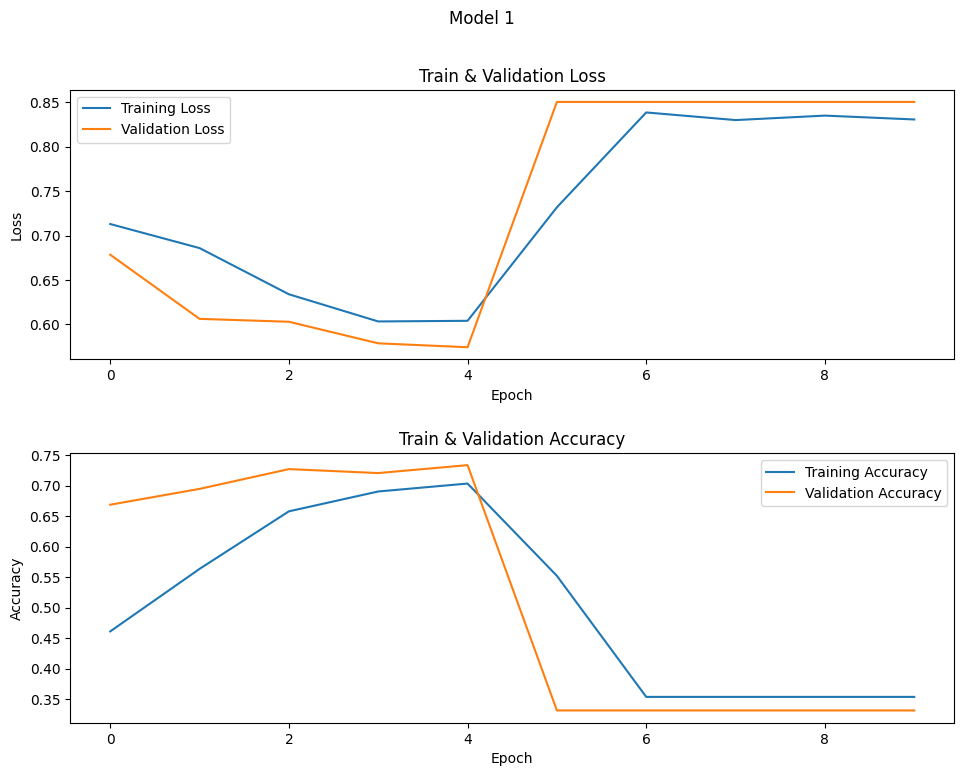

              precision    recall  f1-score   support

Non-diabetic       0.00      0.00      0.00       103
    Diabetic       0.33      1.00      0.50        51

    accuracy                           0.33       154
   macro avg       0.17      0.50      0.25       154
weighted avg       0.11      0.33      0.16       154

accuracy on the model was 33.116883116883116%


/usr/local/lib/python3.9/dist-packages/sklearn/metrics/_classification.py:1334: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/usr/local/lib/python3.9/dist-packages/sklearn/metrics/_classification.py:1334: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/usr/local/lib/python3.9/dist-packages/sklearn/metrics/_classification.py:1334: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


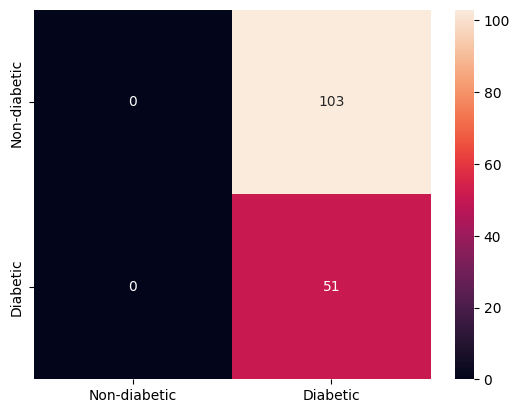

In [44]:
#model1
evalFunction(model1, loaderNormal, epochLog1, trainAccLog1, trainLossLog1, validationAccLog1, validationLossLog1, 'Model 1')

<Figure size 1000x800 with 0 Axes>

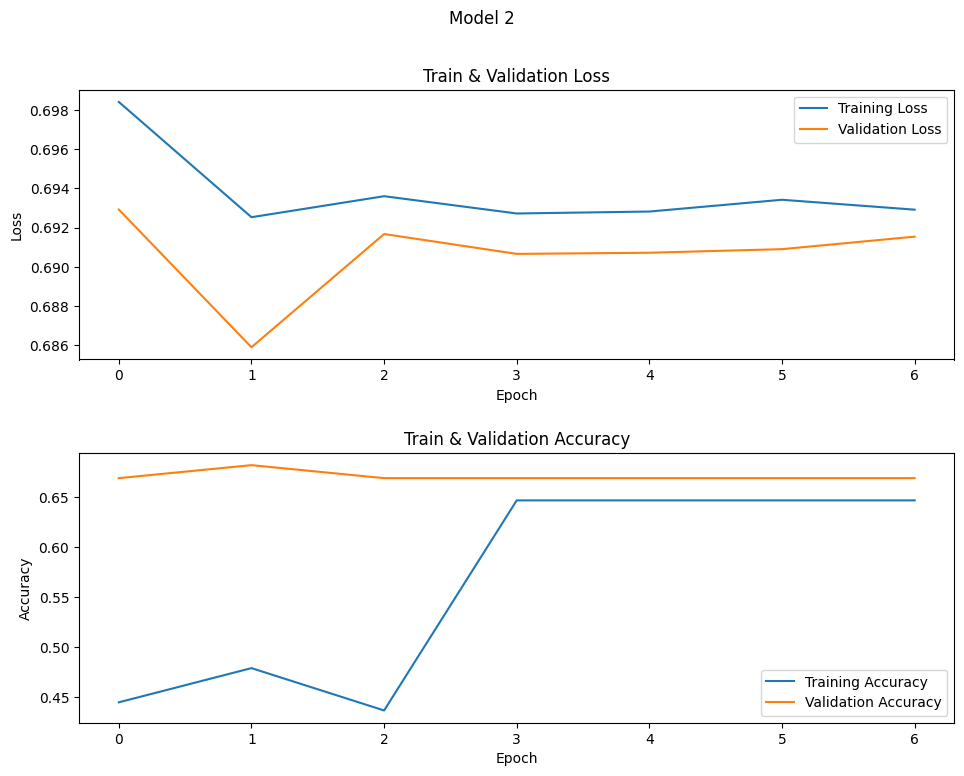

              precision    recall  f1-score   support

Non-diabetic       0.67      1.00      0.80       103
    Diabetic       0.00      0.00      0.00        51

    accuracy                           0.67       154
   macro avg       0.33      0.50      0.40       154
weighted avg       0.45      0.67      0.54       154

accuracy on the model was 66.88311688311688%


/usr/local/lib/python3.9/dist-packages/sklearn/metrics/_classification.py:1334: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/usr/local/lib/python3.9/dist-packages/sklearn/metrics/_classification.py:1334: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/usr/local/lib/python3.9/dist-packages/sklearn/metrics/_classification.py:1334: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


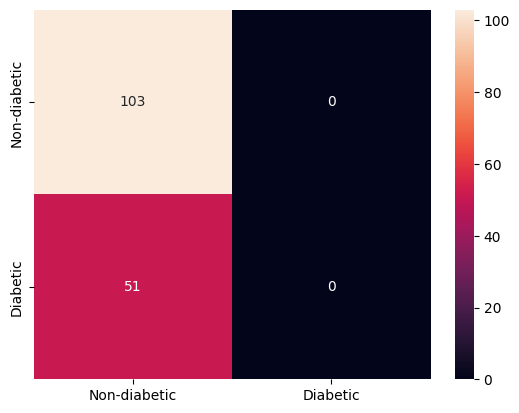

In [45]:
#model2
evalFunction(model2, loaderNormal, epochLog2, trainAccLog2, trainLossLog2, validationAccLog2, validationLossLog2, 'Model 2')

<Figure size 1000x800 with 0 Axes>

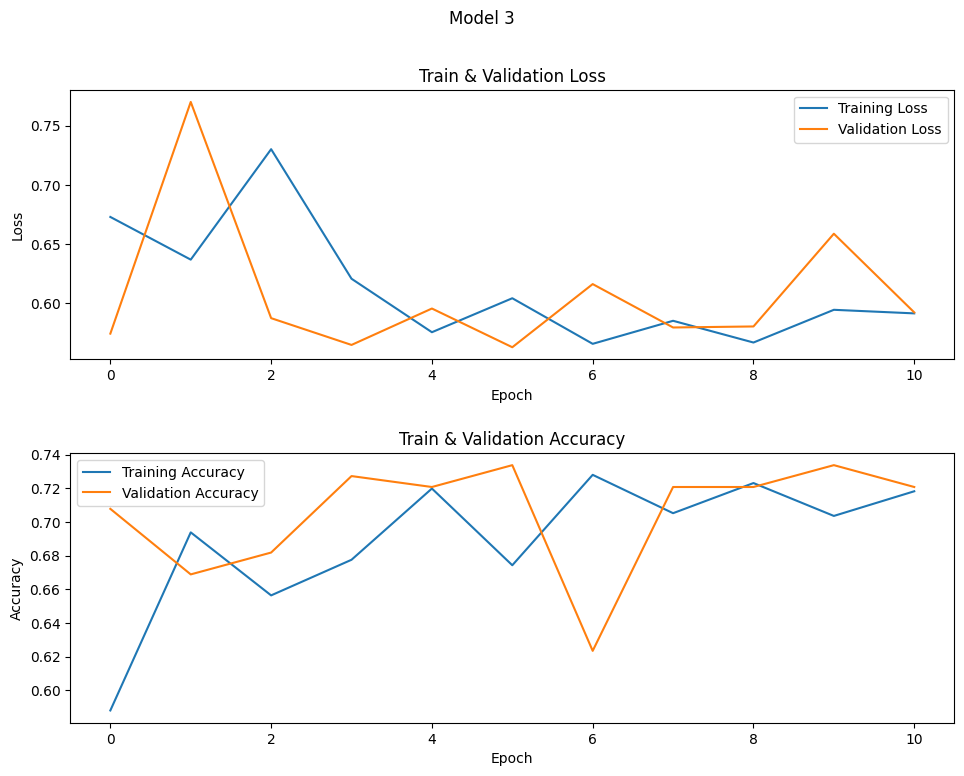

              precision    recall  f1-score   support

Non-diabetic       0.79      0.80      0.79       103
    Diabetic       0.58      0.57      0.57        51

    accuracy                           0.72       154
   macro avg       0.68      0.68      0.68       154
weighted avg       0.72      0.72      0.72       154

accuracy on the model was 72.07792207792208%


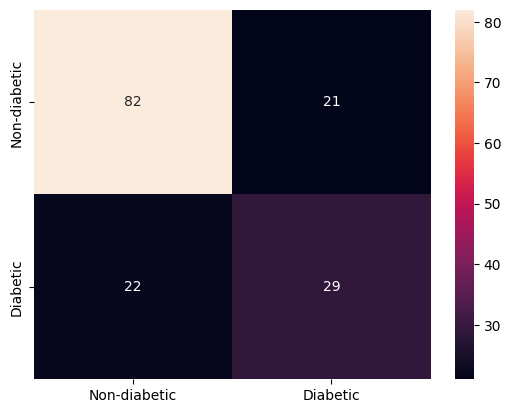

In [46]:
#model3
evalFunction(model3, loaderNormal, epochLog3, trainAccLog3, trainLossLog3, validationAccLog3, validationLossLog3, 'Model 3')

<Figure size 1000x800 with 0 Axes>

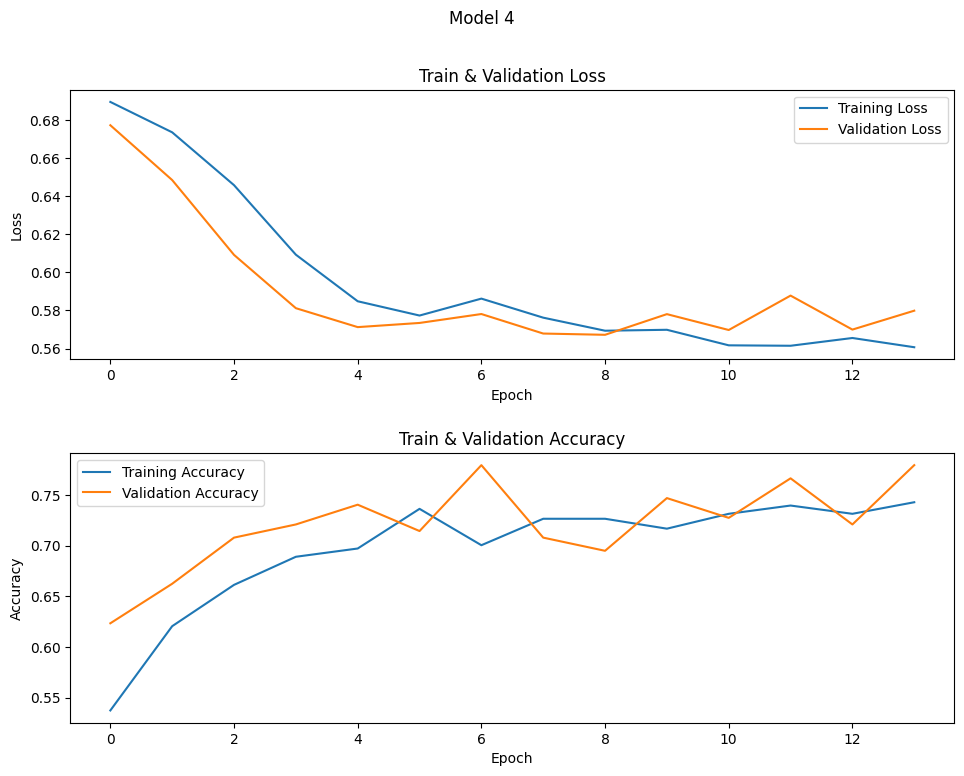

              precision    recall  f1-score   support

Non-diabetic       0.79      0.90      0.85       103
    Diabetic       0.73      0.53      0.61        51

    accuracy                           0.78       154
   macro avg       0.76      0.72      0.73       154
weighted avg       0.77      0.78      0.77       154

accuracy on the model was 77.92207792207792%


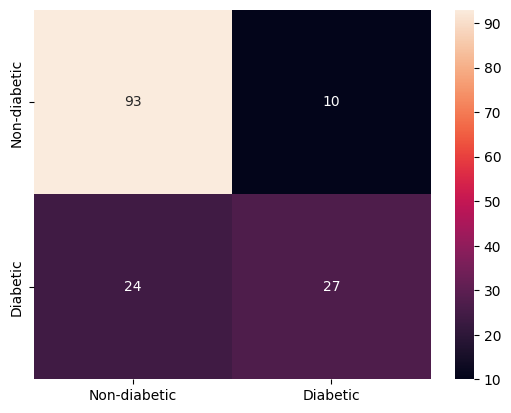

In [47]:
#model4
evalFunction(model4, loaderNormal, epochLog4, trainAccLog4, trainLossLog4, validationAccLog4, validationLossLog4, 'Model 4')

## Evaluation high corr cols

<Figure size 1000x800 with 0 Axes>

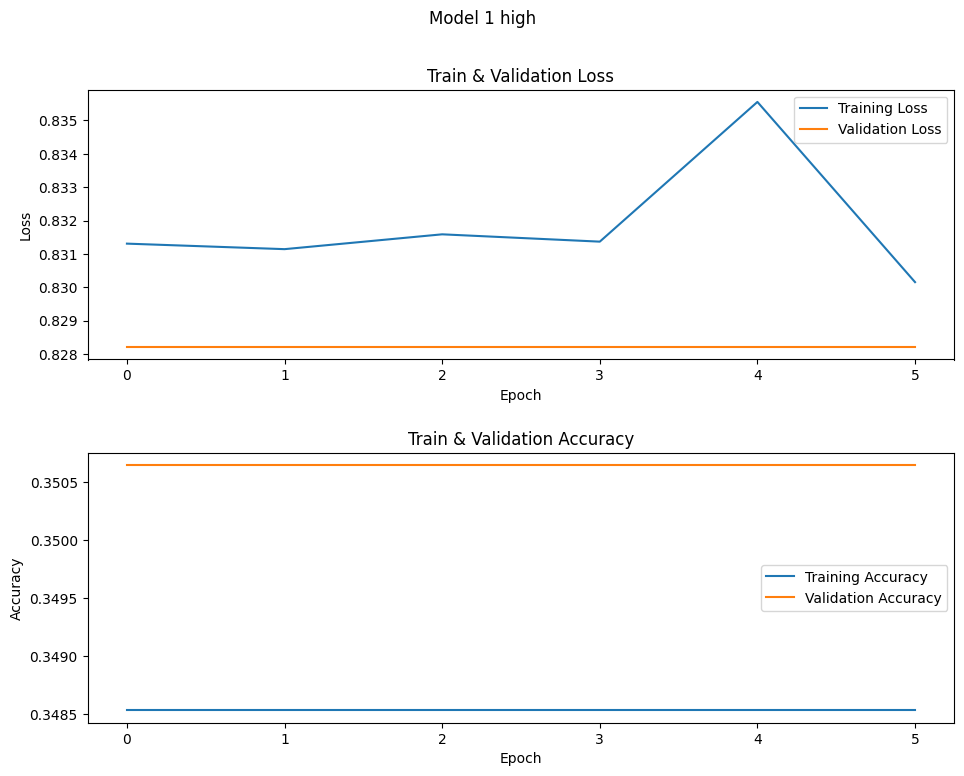

              precision    recall  f1-score   support

Non-diabetic       0.00      0.00      0.00       100
    Diabetic       0.35      1.00      0.52        54

    accuracy                           0.35       154
   macro avg       0.18      0.50      0.26       154
weighted avg       0.12      0.35      0.18       154

accuracy on the model was 35.064935064935064%


/usr/local/lib/python3.9/dist-packages/sklearn/metrics/_classification.py:1334: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/usr/local/lib/python3.9/dist-packages/sklearn/metrics/_classification.py:1334: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/usr/local/lib/python3.9/dist-packages/sklearn/metrics/_classification.py:1334: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


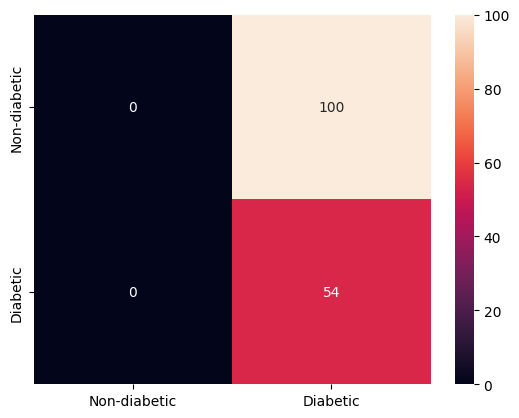

In [48]:
#model1high
evalFunction(model1high, loaderHigh, highEpochLog1, highTrainAccLog1, highTrainLossLog1, highValidationAccLog1, highValidationLossLog1, 'Model 1 high')

<Figure size 1000x800 with 0 Axes>

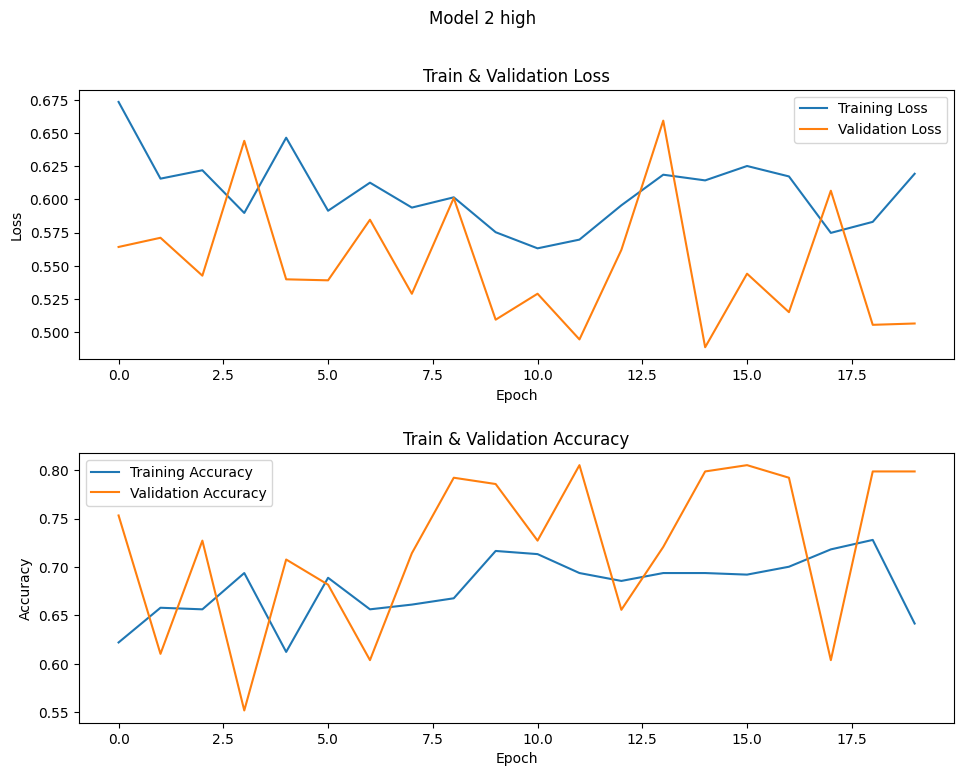

              precision    recall  f1-score   support

Non-diabetic       0.89      0.79      0.84       100
    Diabetic       0.68      0.81      0.74        54

    accuracy                           0.80       154
   macro avg       0.78      0.80      0.79       154
weighted avg       0.81      0.80      0.80       154

accuracy on the model was 79.87012987012987%


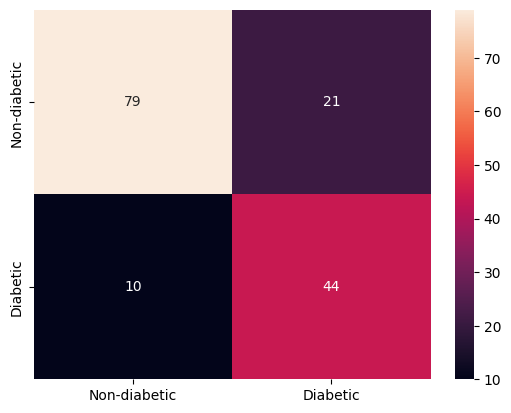

In [49]:
#model2high
evalFunction(model2high, loaderHigh, highEpochLog2, highTrainAccLog2, highTrainLossLog2, highValidationAccLog2, highValidationLossLog2, 'Model 2 high')

<Figure size 1000x800 with 0 Axes>

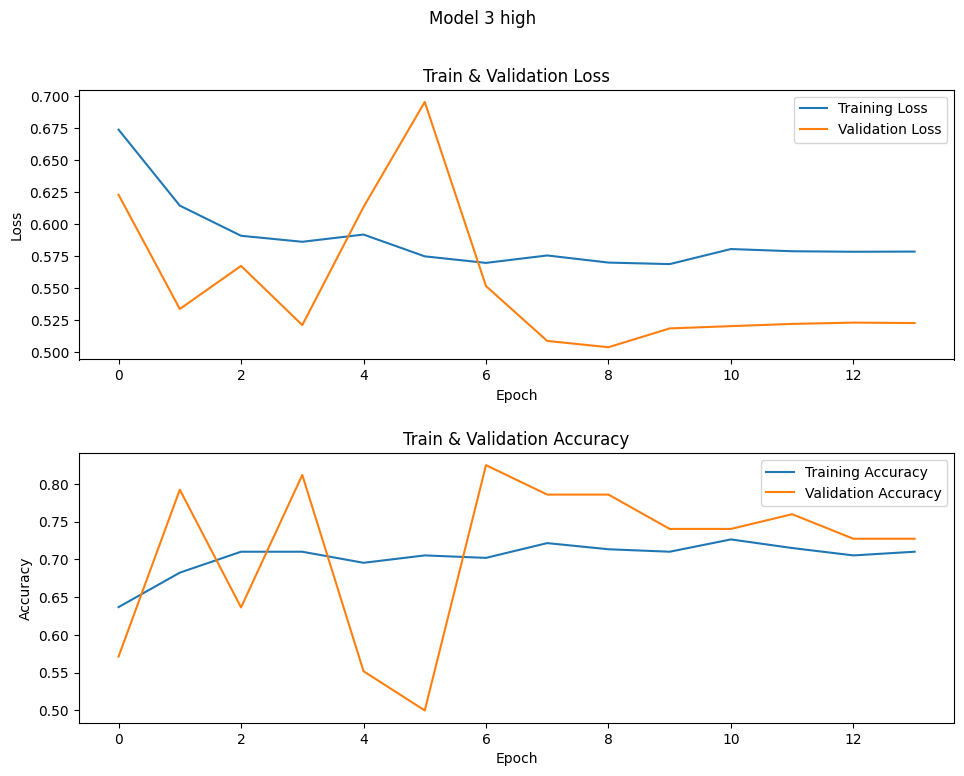

              precision    recall  f1-score   support

Non-diabetic       0.93      0.63      0.75       100
    Diabetic       0.57      0.91      0.70        54

    accuracy                           0.73       154
   macro avg       0.75      0.77      0.72       154
weighted avg       0.80      0.73      0.73       154

accuracy on the model was 72.72727272727273%


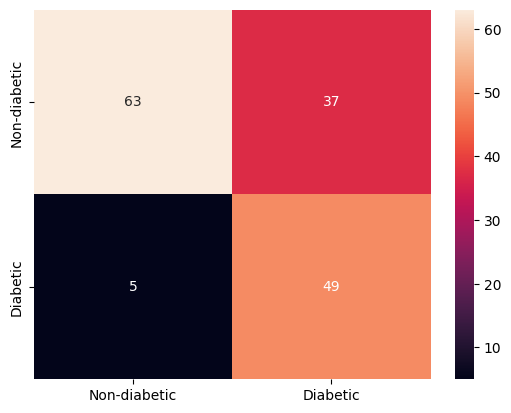

In [50]:
#model3high
evalFunction(model3high, loaderHigh, highEpochLog3, highTrainAccLog3, highTrainLossLog3, highValidationAccLog3, highValidationLossLog3, 'Model 3 high')

<Figure size 1000x800 with 0 Axes>

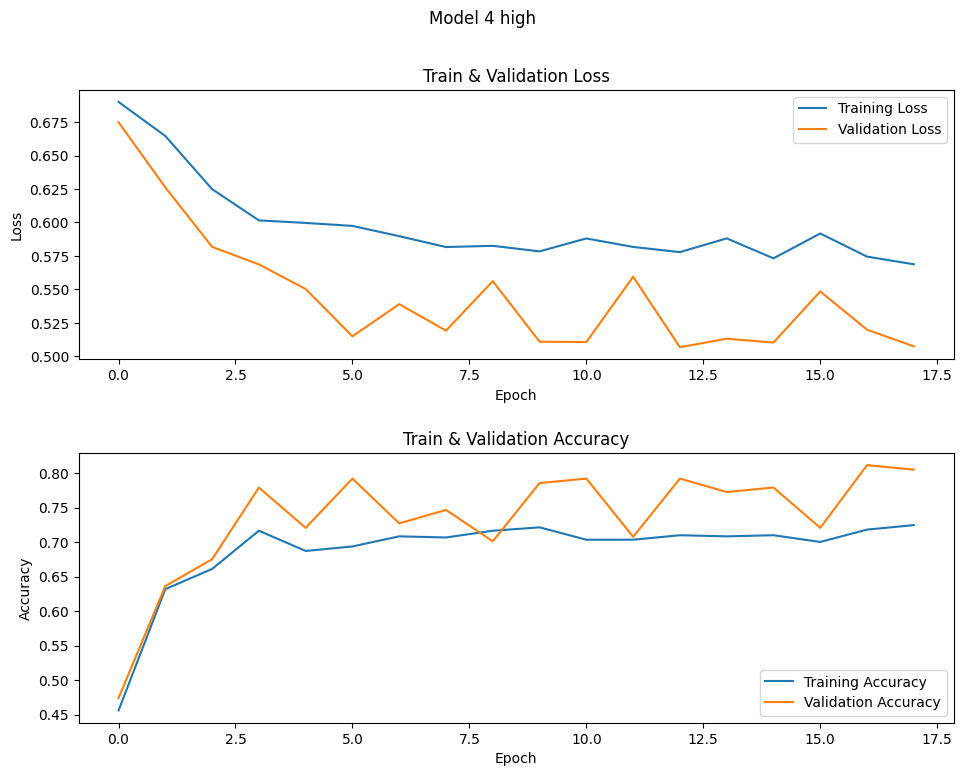

              precision    recall  f1-score   support

Non-diabetic       0.86      0.84      0.85       100
    Diabetic       0.71      0.74      0.73        54

    accuracy                           0.81       154
   macro avg       0.79      0.79      0.79       154
weighted avg       0.81      0.81      0.81       154

accuracy on the model was 80.51948051948052%


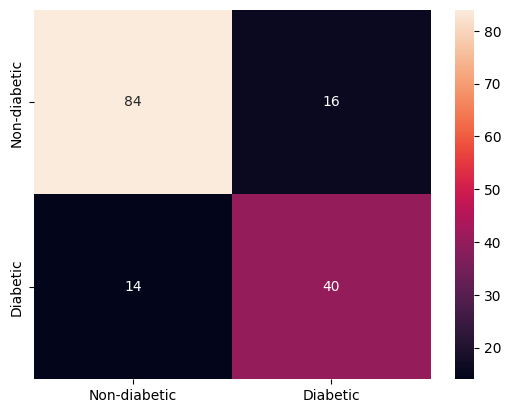

In [51]:
#model4high
evalFunction(model4high, loaderHigh, highEpochLog4, highTrainAccLog4, highTrainLossLog4, highValidationAccLog4, highValidationLossLog4, 'Model 4 high')

## Best Model

Based on the model above, the performance of model4high which are using high correlation columns exceed all the other model. Therefore, we decided to use this model to do some experiments with it

## Using logits (sigmoid prediction)

In [52]:
def trainingFunctionLogits(model, epochs, loader, size, criterion, optimizer, threshold=0.5, patience=5, device=device):
    trainAccLog = []
    trainLossLog = []
    validationAccLog = []
    validationLossLog = []
    epochLog = []
    model.to(device)
    earlyStop = 0
    bestLoss = float('inf')
    sim = nn.Sigmoid()

    for epoch in range(epochs):
        print(f'Epoch {epoch+1}/{epochs}')
        print('-'*10)
        epochLog.append(epoch)
        for phase in ['train', 'val']:
            if phase=='train':
                model.train()
            else:
                model.eval()
            runningLoss = .0
            runningAcc = .0
            for features, targets in tqdm(loader[phase], desc='Batch', leave=False):
                feature = features.to(device)
                target = targets.to(device)
                optimizer.zero_grad()
                with torch.set_grad_enabled(phase == 'train'):
                    outputs = model(feature)
                    predProbs = sim(outputs)
                    pred = (predProbs >= threshold).float()
                    # print(outputs.shape)
                    # print(target.shape)
                    loss = criterion(outputs.squeeze(), target)
                    if phase=='train':
                        loss.backward()
                        optimizer.step()
                runningLoss += loss.item() * features.size(0)
                # print(pred)
                # print(target)
                runningAcc += torch.sum(pred.squeeze() == target).item()
                del feature, target, outputs, pred, predProbs
                torch.cuda.empty_cache()
            epochLoss = runningLoss / size[phase]
            epochAcc = runningAcc / size[phase]
            if phase == 'train':
                trainAccLog.append(epochAcc)
                trainLossLog.append(epochLoss)
            elif phase == 'val':
                validationAccLog.append(epochAcc)
                validationLossLog.append(epochLoss)
                if patience:
                    if epochLoss < bestLoss:
                        bestLoss = epochLoss
                        earlyStop = 0
                    else:
                        earlyStop += 1
            tqdm.write(f'{phase} phase Accuracy : {epochAcc:.4f} and Loss : {epochLoss:.4f}')

        if earlyStop >= patience:
            tqdm.write(f'Early stopping, no improvement in {patience} epochs')
            break
        print()
    tqdm.write('Training Finished')
    return (model, epochLog, trainAccLog, trainLossLog, validationAccLog, validationLossLog)

In [53]:
class modelexperiment(nn.Module):
    def __init__(self):
        super(modelexperiment, self).__init__()
        self.inputLayer = nn.Linear(in_features=inFeatureHigh, out_features=16)
        self.relu1 = nn.ReLU()
        self.hidden1 = nn.Linear(in_features=16, out_features=8)
        self.relu2 = nn.ReLU()
        self.outputLayer = nn.Linear(in_features=8, out_features=1)
    def forward(self, x):
        x = self.relu1(self.inputLayer(x))
        x = self.relu2(self.hidden1(x))
        x = self.outputLayer(x)
        return x
experimentmodel = modelexperiment()
summary(experimentmodel, input_size=(1,1, inFeatureHigh))

Layer (type:depth-idx)                   Output Shape              Param #
modelexperiment                          [1, 1, 1]                 --
├─Linear: 1-1                            [1, 1, 16]                80
├─ReLU: 1-2                              [1, 1, 16]                --
├─Linear: 1-3                            [1, 1, 8]                 136
├─ReLU: 1-4                              [1, 1, 8]                 --
├─Linear: 1-5                            [1, 1, 1]                 9
Total params: 225
Trainable params: 225
Non-trainable params: 0
Total mult-adds (M): 0.00
Input size (MB): 0.00
Forward/backward pass size (MB): 0.00
Params size (MB): 0.00
Estimated Total Size (MB): 0.00

In [54]:
def evalFunctionLogits(model, loader, epochLog, trainAcc, trainLoss, validationAcc, validationLoss, supTitle, device=device):
    plt.figure(figsize=(10,8))
    total = 0
    correct = 0
    pred = []
    truth = []
    sim = nn.Sigmoid()

    with torch.no_grad():
        model.eval()
        for i, (features, targets) in enumerate(loader['val']):
            feature = features.to(device)
            target = targets.to(device)

            outputs = model(feature)
            # _, preds = torch.max(outputs, 1)
            predProbs = sim(outputs)
            preds = (predProbs >= threshold).float()

            pred.extend(preds.data.cpu().numpy())
            truth.extend(target.data.cpu().numpy())

            total+=target.size(0)
            correct+= torch.sum(preds.squeeze()==target).item()
        
        visLog(epochLog, trainAcc, trainLoss, validationAcc, validationLoss, supTitle)

        print(classification_report(truth, pred, target_names=classNames))
        print(f'accuracy on the model was {correct / total}%')
        cfMatrix = confusion_matrix(truth, pred)
        df = pd.DataFrame(cfMatrix, index=[i for i in classNames], columns=[i for i in classNames])
        sns.heatmap(df, annot=True, fmt='.0f')


In [55]:
cwHighWeight = getPosWeight(loaderHigh['train'])
cwHighPosWeight = cwHighWeight.to(device)
print(cwHighPosWeight)
print(cwHighPosWeight.shape)

tensor([1.8692], device='cuda:0')
torch.Size([1])


In [56]:
#model4
criterionExperiment = nn.BCEWithLogitsLoss(pos_weight=cwHighPosWeight)
optimizerExperiment = optim.SGD(experimentmodel.parameters(), lr=0.01)
experimentModel, experimentEpochLog, experimentTrainAccLog, experimentLossLog, experimentValidationLog, experimentValidationLoss = trainingFunctionLogits(experimentmodel, epochs, loaderHigh, sizeHigh, criterionExperiment, optimizerExperiment, patience=10)

Epoch 1/250
----------


train phase Accuracy : 0.6515 and Loss : 0.9360


val phase Accuracy : 0.6494 and Loss : 0.9274

Epoch 2/250
----------


train phase Accuracy : 0.6515 and Loss : 0.9190


val phase Accuracy : 0.6494 and Loss : 0.9163

Epoch 3/250
----------


train phase Accuracy : 0.6515 and Loss : 0.9115


val phase Accuracy : 0.6494 and Loss : 0.9107

Epoch 4/250
----------


train phase Accuracy : 0.6515 and Loss : 0.9078


val phase Accuracy : 0.6494 and Loss : 0.9075

Epoch 5/250
----------


train phase Accuracy : 0.6515 and Loss : 0.9055


val phase Accuracy : 0.6494 and Loss : 0.9054

Epoch 6/250
----------


train phase Accuracy : 0.6515 and Loss : 0.9039


val phase Accuracy : 0.6494 and Loss : 0.9039

Epoch 7/250
----------


train phase Accuracy : 0.6515 and Loss : 0.9029


val phase Accuracy : 0.6494 and Loss : 0.9026

Epoch 8/250
----------


train phase Accuracy : 0.6466 and Loss : 0.9019


val phase Accuracy : 0.6494 and Loss : 0.9014

Epoch 9/250
----------


train phase Accuracy : 0.6531 and Loss : 0.9010


val phase Accuracy : 0.6623 and Loss : 0.9002

Epoch 10/250
----------


train phase Accuracy : 0.6759 and Loss : 0.9001


val phase Accuracy : 0.6753 and Loss : 0.8990

Epoch 11/250
----------


train phase Accuracy : 0.6678 and Loss : 0.8991


val phase Accuracy : 0.7078 and Loss : 0.8977

Epoch 12/250
----------


train phase Accuracy : 0.6743 and Loss : 0.8981


val phase Accuracy : 0.7792 and Loss : 0.8964

Epoch 13/250
----------


train phase Accuracy : 0.6922 and Loss : 0.8971


val phase Accuracy : 0.7987 and Loss : 0.8950

Epoch 14/250
----------


train phase Accuracy : 0.6857 and Loss : 0.8960


val phase Accuracy : 0.7857 and Loss : 0.8935

Epoch 15/250
----------


train phase Accuracy : 0.6906 and Loss : 0.8946


val phase Accuracy : 0.7597 and Loss : 0.8918

Epoch 16/250
----------


train phase Accuracy : 0.6922 and Loss : 0.8936


val phase Accuracy : 0.7273 and Loss : 0.8900

Epoch 17/250
----------


train phase Accuracy : 0.6922 and Loss : 0.8922


val phase Accuracy : 0.7273 and Loss : 0.8880

Epoch 18/250
----------


train phase Accuracy : 0.6726 and Loss : 0.8904


val phase Accuracy : 0.7532 and Loss : 0.8859

Epoch 19/250
----------


train phase Accuracy : 0.6824 and Loss : 0.8887


val phase Accuracy : 0.7338 and Loss : 0.8837

Epoch 20/250
----------


train phase Accuracy : 0.6775 and Loss : 0.8871


val phase Accuracy : 0.7273 and Loss : 0.8813

Epoch 21/250
----------


train phase Accuracy : 0.6971 and Loss : 0.8851


val phase Accuracy : 0.6948 and Loss : 0.8788

Epoch 22/250
----------


train phase Accuracy : 0.6840 and Loss : 0.8832


val phase Accuracy : 0.6948 and Loss : 0.8760

Epoch 23/250
----------


train phase Accuracy : 0.6938 and Loss : 0.8811


val phase Accuracy : 0.7013 and Loss : 0.8730

Epoch 24/250
----------


train phase Accuracy : 0.6792 and Loss : 0.8788


val phase Accuracy : 0.7338 and Loss : 0.8698

Epoch 25/250
----------


train phase Accuracy : 0.6840 and Loss : 0.8762


val phase Accuracy : 0.7468 and Loss : 0.8665

Epoch 26/250
----------


train phase Accuracy : 0.6759 and Loss : 0.8735


val phase Accuracy : 0.7338 and Loss : 0.8627

Epoch 27/250
----------


train phase Accuracy : 0.6596 and Loss : 0.8698


val phase Accuracy : 0.7468 and Loss : 0.8590

Epoch 28/250
----------


train phase Accuracy : 0.6743 and Loss : 0.8680


val phase Accuracy : 0.7338 and Loss : 0.8544

Epoch 29/250
----------


train phase Accuracy : 0.6873 and Loss : 0.8648


val phase Accuracy : 0.7273 and Loss : 0.8499

Epoch 30/250
----------


train phase Accuracy : 0.6775 and Loss : 0.8612


val phase Accuracy : 0.7338 and Loss : 0.8451

Epoch 31/250
----------


train phase Accuracy : 0.6710 and Loss : 0.8575


val phase Accuracy : 0.7273 and Loss : 0.8400

Epoch 32/250
----------


train phase Accuracy : 0.6759 and Loss : 0.8539


val phase Accuracy : 0.7273 and Loss : 0.8347

Epoch 33/250
----------


train phase Accuracy : 0.6808 and Loss : 0.8504


val phase Accuracy : 0.7273 and Loss : 0.8292

Epoch 34/250
----------


train phase Accuracy : 0.6792 and Loss : 0.8460


val phase Accuracy : 0.6883 and Loss : 0.8240

Epoch 35/250
----------


train phase Accuracy : 0.6726 and Loss : 0.8415


val phase Accuracy : 0.7338 and Loss : 0.8168

Epoch 36/250
----------


train phase Accuracy : 0.6726 and Loss : 0.8374


val phase Accuracy : 0.7403 and Loss : 0.8105

Epoch 37/250
----------


train phase Accuracy : 0.6824 and Loss : 0.8338


val phase Accuracy : 0.7338 and Loss : 0.8041

Epoch 38/250
----------


train phase Accuracy : 0.6824 and Loss : 0.8292


val phase Accuracy : 0.7338 and Loss : 0.7978

Epoch 39/250
----------


train phase Accuracy : 0.6824 and Loss : 0.8246


val phase Accuracy : 0.7403 and Loss : 0.7907

Epoch 40/250
----------


train phase Accuracy : 0.6857 and Loss : 0.8202


val phase Accuracy : 0.7338 and Loss : 0.7847

Epoch 41/250
----------


train phase Accuracy : 0.6840 and Loss : 0.8172


val phase Accuracy : 0.7338 and Loss : 0.7783

Epoch 42/250
----------


train phase Accuracy : 0.6889 and Loss : 0.8124


val phase Accuracy : 0.7273 and Loss : 0.7725

Epoch 43/250
----------


train phase Accuracy : 0.6922 and Loss : 0.8077


val phase Accuracy : 0.7468 and Loss : 0.7643

Epoch 44/250
----------


train phase Accuracy : 0.6840 and Loss : 0.8049


val phase Accuracy : 0.7078 and Loss : 0.7632

Epoch 45/250
----------


train phase Accuracy : 0.6922 and Loss : 0.8014


val phase Accuracy : 0.7208 and Loss : 0.7534

Epoch 46/250
----------


train phase Accuracy : 0.6987 and Loss : 0.7963


val phase Accuracy : 0.7208 and Loss : 0.7499

Epoch 47/250
----------


train phase Accuracy : 0.7052 and Loss : 0.7959


val phase Accuracy : 0.7403 and Loss : 0.7396

Epoch 48/250
----------


train phase Accuracy : 0.7052 and Loss : 0.7910


val phase Accuracy : 0.7662 and Loss : 0.7315

Epoch 49/250
----------


train phase Accuracy : 0.7117 and Loss : 0.7853


val phase Accuracy : 0.6948 and Loss : 0.7419

Epoch 50/250
----------


train phase Accuracy : 0.6971 and Loss : 0.7842


val phase Accuracy : 0.7792 and Loss : 0.7208

Epoch 51/250
----------


train phase Accuracy : 0.6987 and Loss : 0.7839


val phase Accuracy : 0.7597 and Loss : 0.7139

Epoch 52/250
----------


train phase Accuracy : 0.7052 and Loss : 0.7782


val phase Accuracy : 0.7662 and Loss : 0.7101

Epoch 53/250
----------


train phase Accuracy : 0.7003 and Loss : 0.7763


val phase Accuracy : 0.7662 and Loss : 0.7047

Epoch 54/250
----------


train phase Accuracy : 0.7215 and Loss : 0.7685


val phase Accuracy : 0.7013 and Loss : 0.7203

Epoch 55/250
----------


train phase Accuracy : 0.7085 and Loss : 0.7706


val phase Accuracy : 0.7922 and Loss : 0.6912

Epoch 56/250
----------


train phase Accuracy : 0.7248 and Loss : 0.7677


val phase Accuracy : 0.7468 and Loss : 0.6969

Epoch 57/250
----------


train phase Accuracy : 0.7199 and Loss : 0.7664


val phase Accuracy : 0.7727 and Loss : 0.6806

Epoch 58/250
----------


train phase Accuracy : 0.7052 and Loss : 0.7630


val phase Accuracy : 0.7792 and Loss : 0.6774

Epoch 59/250
----------


train phase Accuracy : 0.7101 and Loss : 0.7603


val phase Accuracy : 0.7792 and Loss : 0.6705

Epoch 60/250
----------


train phase Accuracy : 0.7101 and Loss : 0.7549


val phase Accuracy : 0.7987 and Loss : 0.6675

Epoch 61/250
----------


train phase Accuracy : 0.7150 and Loss : 0.7535


val phase Accuracy : 0.7338 and Loss : 0.6760

Epoch 62/250
----------


train phase Accuracy : 0.7101 and Loss : 0.7532


val phase Accuracy : 0.7792 and Loss : 0.6567

Epoch 63/250
----------


train phase Accuracy : 0.7134 and Loss : 0.7496


val phase Accuracy : 0.7857 and Loss : 0.6523

Epoch 64/250
----------


train phase Accuracy : 0.7182 and Loss : 0.7490


val phase Accuracy : 0.7662 and Loss : 0.6639

Epoch 65/250
----------


train phase Accuracy : 0.7052 and Loss : 0.7471


val phase Accuracy : 0.7922 and Loss : 0.6478

Epoch 66/250
----------


train phase Accuracy : 0.7248 and Loss : 0.7436


val phase Accuracy : 0.7857 and Loss : 0.6403

Epoch 67/250
----------


train phase Accuracy : 0.7101 and Loss : 0.7429


val phase Accuracy : 0.7792 and Loss : 0.6375

Epoch 68/250
----------


train phase Accuracy : 0.7166 and Loss : 0.7414


val phase Accuracy : 0.7727 and Loss : 0.6352

Epoch 69/250
----------


train phase Accuracy : 0.7117 and Loss : 0.7413


val phase Accuracy : 0.7792 and Loss : 0.6414

Epoch 70/250
----------


train phase Accuracy : 0.7215 and Loss : 0.7380


val phase Accuracy : 0.7727 and Loss : 0.6357

Epoch 71/250
----------


train phase Accuracy : 0.7215 and Loss : 0.7358


val phase Accuracy : 0.7857 and Loss : 0.6266

Epoch 72/250
----------


train phase Accuracy : 0.7134 and Loss : 0.7311


val phase Accuracy : 0.7857 and Loss : 0.6282

Epoch 73/250
----------


train phase Accuracy : 0.7199 and Loss : 0.7306


val phase Accuracy : 0.7662 and Loss : 0.6359

Epoch 74/250
----------


train phase Accuracy : 0.7150 and Loss : 0.7316


val phase Accuracy : 0.7987 and Loss : 0.6198

Epoch 75/250
----------


train phase Accuracy : 0.7134 and Loss : 0.7317


val phase Accuracy : 0.7727 and Loss : 0.6216

Epoch 76/250
----------


train phase Accuracy : 0.7068 and Loss : 0.7311


val phase Accuracy : 0.7792 and Loss : 0.6228

Epoch 77/250
----------


train phase Accuracy : 0.7101 and Loss : 0.7279


val phase Accuracy : 0.7922 and Loss : 0.6146

Epoch 78/250
----------


train phase Accuracy : 0.7215 and Loss : 0.7229


val phase Accuracy : 0.7532 and Loss : 0.6311

Epoch 79/250
----------


train phase Accuracy : 0.7182 and Loss : 0.7262


val phase Accuracy : 0.7922 and Loss : 0.6119

Epoch 80/250
----------


train phase Accuracy : 0.7101 and Loss : 0.7269


val phase Accuracy : 0.7727 and Loss : 0.6136

Epoch 81/250
----------


train phase Accuracy : 0.7166 and Loss : 0.7245


val phase Accuracy : 0.7857 and Loss : 0.6087

Epoch 82/250
----------


train phase Accuracy : 0.7215 and Loss : 0.7255


val phase Accuracy : 0.7922 and Loss : 0.6090

Epoch 83/250
----------


train phase Accuracy : 0.7134 and Loss : 0.7256


val phase Accuracy : 0.7857 and Loss : 0.6119

Epoch 84/250
----------


train phase Accuracy : 0.7068 and Loss : 0.7217


val phase Accuracy : 0.7727 and Loss : 0.6144

Epoch 85/250
----------


train phase Accuracy : 0.7101 and Loss : 0.7203


val phase Accuracy : 0.7532 and Loss : 0.6233

Epoch 86/250
----------


train phase Accuracy : 0.6987 and Loss : 0.7246


val phase Accuracy : 0.7857 and Loss : 0.6098

Epoch 87/250
----------


train phase Accuracy : 0.7199 and Loss : 0.7211


val phase Accuracy : 0.7857 and Loss : 0.6059

Epoch 88/250
----------


train phase Accuracy : 0.7020 and Loss : 0.7208


val phase Accuracy : 0.7857 and Loss : 0.6043

Epoch 89/250
----------


train phase Accuracy : 0.7150 and Loss : 0.7204


val phase Accuracy : 0.7922 and Loss : 0.6038

Epoch 90/250
----------


train phase Accuracy : 0.7378 and Loss : 0.7169


val phase Accuracy : 0.7143 and Loss : 0.6520

Epoch 91/250
----------


train phase Accuracy : 0.7085 and Loss : 0.7207


val phase Accuracy : 0.7792 and Loss : 0.6073

Epoch 92/250
----------


train phase Accuracy : 0.7166 and Loss : 0.7196


val phase Accuracy : 0.7792 and Loss : 0.6130

Epoch 93/250
----------


train phase Accuracy : 0.7248 and Loss : 0.7166


val phase Accuracy : 0.7792 and Loss : 0.6110

Epoch 94/250
----------


train phase Accuracy : 0.7150 and Loss : 0.7224


val phase Accuracy : 0.7468 and Loss : 0.6206

Epoch 95/250
----------


train phase Accuracy : 0.7182 and Loss : 0.7183


val phase Accuracy : 0.7532 and Loss : 0.6187

Epoch 96/250
----------


train phase Accuracy : 0.7117 and Loss : 0.7185


val phase Accuracy : 0.7857 and Loss : 0.5984

Epoch 97/250
----------


train phase Accuracy : 0.7199 and Loss : 0.7163


val phase Accuracy : 0.7857 and Loss : 0.6060

Epoch 98/250
----------


train phase Accuracy : 0.7215 and Loss : 0.7132


val phase Accuracy : 0.7922 and Loss : 0.5979

Epoch 99/250
----------


train phase Accuracy : 0.7166 and Loss : 0.7172


val phase Accuracy : 0.7922 and Loss : 0.5964

Epoch 100/250
----------


train phase Accuracy : 0.7150 and Loss : 0.7168


val phase Accuracy : 0.7532 and Loss : 0.6121

Epoch 101/250
----------


train phase Accuracy : 0.7166 and Loss : 0.7164


val phase Accuracy : 0.7987 and Loss : 0.5945

Epoch 102/250
----------


train phase Accuracy : 0.7117 and Loss : 0.7114


val phase Accuracy : 0.7922 and Loss : 0.5968

Epoch 103/250
----------


train phase Accuracy : 0.7215 and Loss : 0.7124


val phase Accuracy : 0.7857 and Loss : 0.5942

Epoch 104/250
----------


train phase Accuracy : 0.7150 and Loss : 0.7147


val phase Accuracy : 0.7922 and Loss : 0.5979

Epoch 105/250
----------


train phase Accuracy : 0.7215 and Loss : 0.7146


val phase Accuracy : 0.7532 and Loss : 0.6078

Epoch 106/250
----------


train phase Accuracy : 0.7068 and Loss : 0.7150


val phase Accuracy : 0.7922 and Loss : 0.5978

Epoch 107/250
----------


train phase Accuracy : 0.7182 and Loss : 0.7170


val phase Accuracy : 0.7532 and Loss : 0.6087

Epoch 108/250
----------


train phase Accuracy : 0.7248 and Loss : 0.7137


val phase Accuracy : 0.7857 and Loss : 0.5917

Epoch 109/250
----------


train phase Accuracy : 0.7036 and Loss : 0.7159


val phase Accuracy : 0.7922 and Loss : 0.5928

Epoch 110/250
----------


train phase Accuracy : 0.7182 and Loss : 0.7123


val phase Accuracy : 0.7532 and Loss : 0.6062

Epoch 111/250
----------


train phase Accuracy : 0.7215 and Loss : 0.7130


val phase Accuracy : 0.7922 and Loss : 0.5912

Epoch 112/250
----------


train phase Accuracy : 0.7182 and Loss : 0.7153


val phase Accuracy : 0.7857 and Loss : 0.5961

Epoch 113/250
----------


train phase Accuracy : 0.7003 and Loss : 0.7140


val phase Accuracy : 0.7987 and Loss : 0.5909

Epoch 114/250
----------


train phase Accuracy : 0.7134 and Loss : 0.7129


val phase Accuracy : 0.7922 and Loss : 0.5959

Epoch 115/250
----------


train phase Accuracy : 0.7101 and Loss : 0.7141


val phase Accuracy : 0.7922 and Loss : 0.5924

Epoch 116/250
----------


train phase Accuracy : 0.7101 and Loss : 0.7123


val phase Accuracy : 0.7273 and Loss : 0.6246

Epoch 117/250
----------


train phase Accuracy : 0.6987 and Loss : 0.7133


val phase Accuracy : 0.7987 and Loss : 0.5900

Epoch 118/250
----------


train phase Accuracy : 0.7101 and Loss : 0.7144


val phase Accuracy : 0.7532 and Loss : 0.6027

Epoch 119/250
----------


train phase Accuracy : 0.7101 and Loss : 0.7117


val phase Accuracy : 0.7403 and Loss : 0.6186

Epoch 120/250
----------


train phase Accuracy : 0.6971 and Loss : 0.7170


val phase Accuracy : 0.7857 and Loss : 0.5912

Epoch 121/250
----------


train phase Accuracy : 0.7313 and Loss : 0.7109


val phase Accuracy : 0.7922 and Loss : 0.5975

Epoch 122/250
----------


train phase Accuracy : 0.7134 and Loss : 0.7121


val phase Accuracy : 0.7273 and Loss : 0.6206

Epoch 123/250
----------


train phase Accuracy : 0.7101 and Loss : 0.7144


val phase Accuracy : 0.7662 and Loss : 0.6006

Epoch 124/250
----------


train phase Accuracy : 0.7199 and Loss : 0.7079


val phase Accuracy : 0.7662 and Loss : 0.6004

Epoch 125/250
----------


train phase Accuracy : 0.7101 and Loss : 0.7132


val phase Accuracy : 0.7857 and Loss : 0.5934

Epoch 126/250
----------


train phase Accuracy : 0.7264 and Loss : 0.7137


val phase Accuracy : 0.7857 and Loss : 0.5978

Epoch 127/250
----------


train phase Accuracy : 0.7231 and Loss : 0.7078


val phase Accuracy : 0.7857 and Loss : 0.5955
Early stopping, no improvement in 10 epochs
Training Finished


<Figure size 1000x800 with 0 Axes>

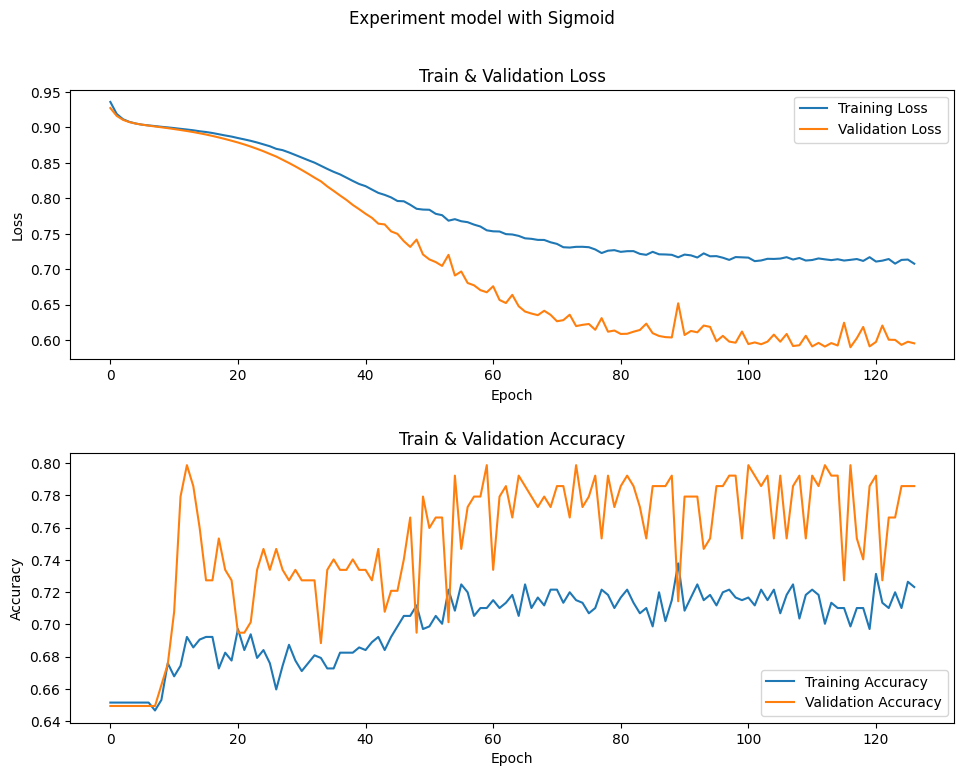

              precision    recall  f1-score   support

Non-diabetic       0.65      1.00      0.79       100
    Diabetic       0.00      0.00      0.00        54

    accuracy                           0.65       154
   macro avg       0.32      0.50      0.39       154
weighted avg       0.42      0.65      0.51       154

accuracy on the model was 0.6493506493506493%


/usr/local/lib/python3.9/dist-packages/sklearn/metrics/_classification.py:1334: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/usr/local/lib/python3.9/dist-packages/sklearn/metrics/_classification.py:1334: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/usr/local/lib/python3.9/dist-packages/sklearn/metrics/_classification.py:1334: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


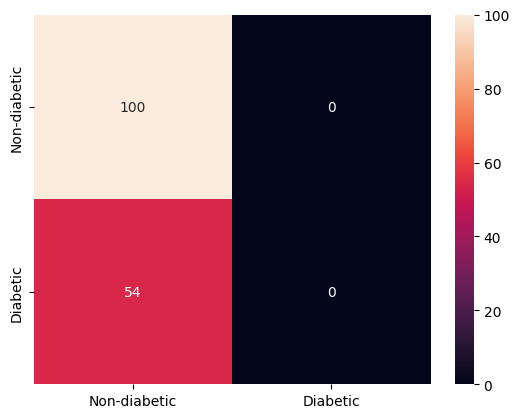

In [57]:
evalFunctionLogits(experimentmodel, loaderHigh, experimentEpochLog, experimentTrainAccLog, experimentLossLog, experimentValidationLog, experimentValidationLoss, 'Experiment model with Sigmoid')

## Best experimental

In [58]:
class model4high(nn.Module):
    def __init__(self):
        super(model4high, self).__init__()
        self.inputLayer = nn.Linear(in_features=inFeatureHigh, out_features=16)
        self.relu1 = nn.ReLU()
        self.hidden1 = nn.Linear(in_features=16, out_features=8)
        self.relu2 = nn.ReLU()
        self.outputLayer = nn.Linear(in_features=8, out_features=2)
    def forward(self, x):
        x = self.relu1(self.inputLayer(x))
        x = self.relu2(self.hidden1(x))
        x = self.outputLayer(x)
        return F.softmax(x, dim=1)
model4high = model4high()
summary(model4high, input_size=(1,1, inFeatureHigh))

Layer (type:depth-idx)                   Output Shape              Param #
model4high                               [1, 1, 2]                 --
├─Linear: 1-1                            [1, 1, 16]                80
├─ReLU: 1-2                              [1, 1, 16]                --
├─Linear: 1-3                            [1, 1, 8]                 136
├─ReLU: 1-4                              [1, 1, 8]                 --
├─Linear: 1-5                            [1, 1, 2]                 18
Total params: 234
Trainable params: 234
Non-trainable params: 0
Total mult-adds (M): 0.00
Input size (MB): 0.00
Forward/backward pass size (MB): 0.00
Params size (MB): 0.00
Estimated Total Size (MB): 0.00

In [59]:
#model4
criterion4high = nn.CrossEntropyLoss(weight=cwHighDevice)
optimizer4high = optim.Adam(model4high.parameters(), lr=0.01)
highTrainedModel4, highEpochLog4, highTrainAccLog4, highTrainLossLog4, highValidationAccLog4, highValidationLossLog4 = trainingFunction(model4high, 500, loaderHigh, sizeHigh, criterion4high, optimizer4high, cw=cwNormal, patience=5)

Epoch 1/500
----------


train phase Accuracy : 0.5912 and Loss : 0.6886


val phase Accuracy : 0.6299 and Loss : 0.6745

Epoch 2/500
----------


train phase Accuracy : 0.6417 and Loss : 0.6696


val phase Accuracy : 0.6883 and Loss : 0.6511

Epoch 3/500
----------


train phase Accuracy : 0.6547 and Loss : 0.6571


val phase Accuracy : 0.6688 and Loss : 0.6258

Epoch 4/500
----------


train phase Accuracy : 0.6384 and Loss : 0.6378


val phase Accuracy : 0.5649 and Loss : 0.6461

Epoch 5/500
----------


train phase Accuracy : 0.6596 and Loss : 0.6234


val phase Accuracy : 0.7143 and Loss : 0.5868

Epoch 6/500
----------


train phase Accuracy : 0.6906 and Loss : 0.6145


val phase Accuracy : 0.6494 and Loss : 0.5995

Epoch 7/500
----------


train phase Accuracy : 0.6743 and Loss : 0.6088


val phase Accuracy : 0.6818 and Loss : 0.5755

Epoch 8/500
----------


train phase Accuracy : 0.6971 and Loss : 0.5970


val phase Accuracy : 0.7987 and Loss : 0.5324

Epoch 9/500
----------


train phase Accuracy : 0.7085 and Loss : 0.5952


val phase Accuracy : 0.7273 and Loss : 0.5622

Epoch 10/500
----------


train phase Accuracy : 0.6792 and Loss : 0.5998


val phase Accuracy : 0.8052 and Loss : 0.5213

Epoch 11/500
----------


train phase Accuracy : 0.6840 and Loss : 0.5991


val phase Accuracy : 0.7532 and Loss : 0.5362

Epoch 12/500
----------


train phase Accuracy : 0.6922 and Loss : 0.5904


val phase Accuracy : 0.7987 and Loss : 0.5480

Epoch 13/500
----------


train phase Accuracy : 0.7068 and Loss : 0.5931


val phase Accuracy : 0.7013 and Loss : 0.5576

Epoch 14/500
----------


train phase Accuracy : 0.6710 and Loss : 0.5951


val phase Accuracy : 0.8052 and Loss : 0.5241

Epoch 15/500
----------


train phase Accuracy : 0.7182 and Loss : 0.5890


val phase Accuracy : 0.7208 and Loss : 0.5514
Early stopping, no improvement in 5 epochs
Training Finished


<Figure size 1000x800 with 0 Axes>

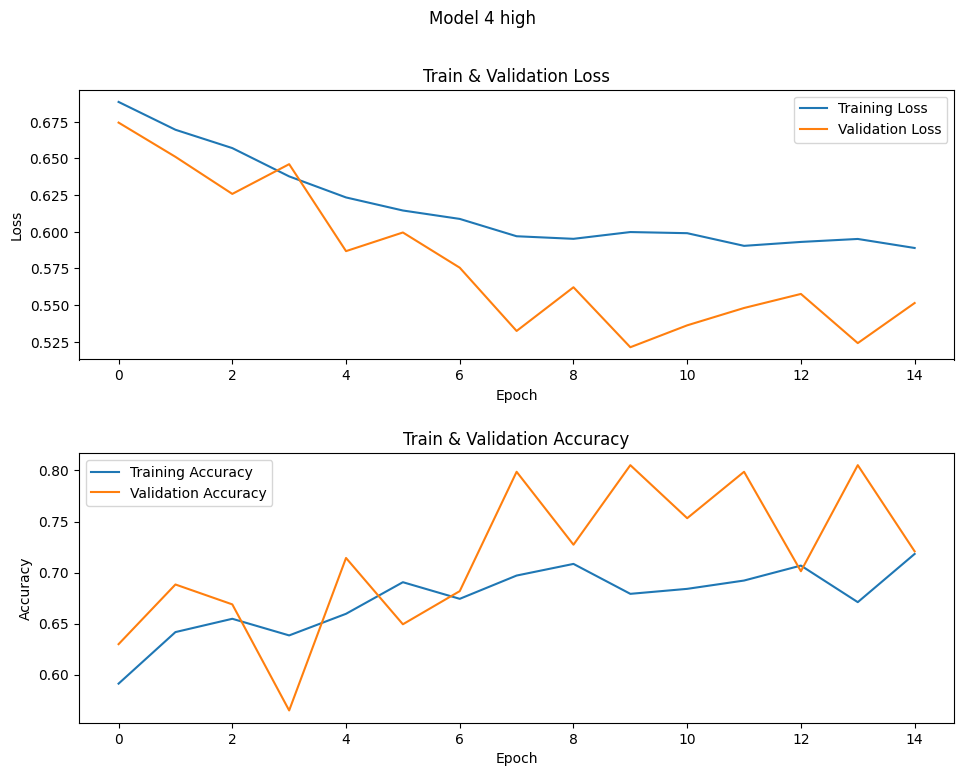

              precision    recall  f1-score   support

Non-diabetic       0.98      0.58      0.73       100
    Diabetic       0.56      0.98      0.71        54

    accuracy                           0.72       154
   macro avg       0.77      0.78      0.72       154
weighted avg       0.83      0.72      0.72       154

accuracy on the model was 72.07792207792208%


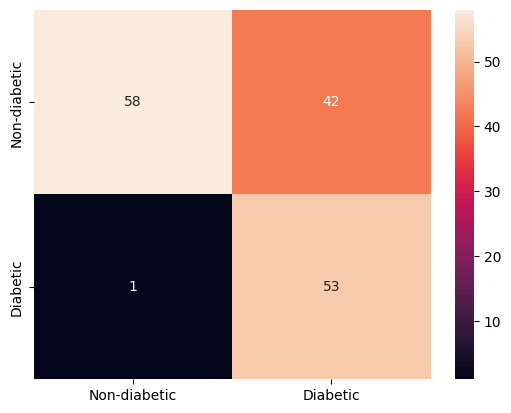

In [60]:
#model4high
evalFunction(model4high, loaderHigh, highEpochLog4, highTrainAccLog4, highTrainLossLog4, highValidationAccLog4, highValidationLossLog4, 'Model 4 high')